# Optical Flow depth calculation

This notebook is to investigate the source of the waves in the data
The waves are more pronounced at when the rotation rate is high

In [1]:
user = 'gerrie'
#user = 'marcvanzyl'

In [2]:
import numpy as np
import cv2, os
from cv2 import aruco
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline

# The board
The following line of the board was updated to reflect the correct scale of the board.  This is necessary becuase the `board` object is used later   
`board = aruco.CharucoBoard_create(7, 5, .04026, .8*.04026, aruco_dict)`

Notice the board object returned.  Is contains all the magic of the CharUco pattern. For the image interpretation and to calibrate the cameras the cameras need a picture of the board and also information about the picture (ie. the details of the board).  This is all contained in the board object. 

In [3]:
board_size = 'experimental setup'

if board_size == '7x5':
    chessboard_num_squares_across = 7
    chessboard_num_squares_up = 5
    chessboard_square_size = 0.04026
    chessboard_aruco_ratio = 0.8   # this is a fraction of chessboard_square_size
    aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)


if board_size == '12x8':
    chessboard_num_squares_across = 12
    chessboard_num_squares_up = 8
    chessboard_square_size = 1
    chessboard_aruco_ratio = 0.7   # this is a fraction of chessboard_square_size
    aruco_dict = aruco.Dictionary_get(aruco.DICT_5X5_250)

elif board_size == 'experimental setup':   
    aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)





The board object contains all the vectors (pointing from the bottom left corner) to each of the corners present on the board.  The two kinds of objects are **aruco markers** and the **checkerboard**.  The aruco markers are called '`markers`' in the code and documentation.  The term `marker corners` means the set of 4 corners around each aruco maker. 

The aruco markers can be extracted from the board using the `aruco.getBoardObjectAndImagePoints(board, makerCorners command)`. 

Once the algorithm detected the markerCorners then it can interpolate between the marker corners to find the checkerboard corners.  The positions of checkerboard "inside" corners can be extracted using the folowing. 

The corners are labeled starting from 0 (bottom left) and going right 

### Now using Charuco

This function:
1. finds the locations of the corners of the aruco squares (`cv2.aruco.detectMarkers`)
1. if markers were found interpolates to find the checkerboard markers between them (`cv2.aruco.interpolateCornersCharuco`)
1. zooms into each checkerboard corner to get sub-pixel accuracy using (`cv2.cornerSubPix`)

In [4]:
def find_checkerboard_corners(img, board, clipLimit=2.0, verbose=False):

    # These are parameters used by the cv2.cornerSubPix function
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    # increase the contraxt
    img = increase_contrast(img, clipLimit=clipLimit)
 
    # convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    detect_params = aruco.CORNER_REFINE_SUBPIX

    # find the aruco corners and the ids of each corner
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict, detect_params)
    
    if verbose:
        print('Found {} aruco marker corners'.format(len(ids)))
    
    if len(ids)>0:
        (retval, charucoCorners,
         charucoIds) = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, board, )
        if verbose:
            print('Found {} checker corners'.format(len(charucoIds)))
        if len(charucoIds)>0:
            # SUB PIXEL DETECTION
            for corner in charucoCorners:
                if verbose:
                    print('Sub pixel optimization:')
                    print(corner)
                cv2.cornerSubPix(gray, corner,
                                 winSize = (5,5),
                                 zeroZone = (-1,-1),
                                 criteria = criteria)
                if verbose:
                    print(corner)
                    print('+++')
        
    return charucoCorners, charucoIds, gray.shape

        

One big problem is that you need to give the stereo calibration only coners that appear in both cameras.  Fortunately, the detection returns the ids of the corners in the `charucoIds`. These `charucoIds` correspond to the numbering system mentioned above (bottom left is 0 and starts going across to the right)

In [5]:
import pickle
# load the camera calibration data
cam_calOF = pickle.load( open('OFCameraCalibration.p', 'rb'))



In [6]:
cam_calOF.keys()

dict_keys(['camera_name', 'ret', 'mtx', 'dist', 'rvecs', 'tvecs'])

# Now we can check

## Camera features:
- sensor size = 3.68 x 2.76 mm  
- sensor resolution  = 3280 × 2464
- focal length = 3.04 mm

$$ d_{mm} = \frac{pix \times 3.68}{3280} $$

The depth can now be found
$$ Z = \frac{T \times f}{d_{mm}} $$

In [7]:
import pandas as pd

In [8]:
# adapted from here https://stackoverflow.com/questions/39308030/how-do-i-increase-the-contrast-of-an-image-in-python-opencv
def increase_contrast(img, clipLimit=3.0, verbose=False):

    if clipLimit>0.0:
        #-----Converting image to LAB Color model----------------------------------- 
        lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        if verbose:
            cv2.imshow("lab",lab)

        #-----Splitting the LAB image to different channels-------------------------
        l, a, b = cv2.split(lab)
        if verbose:
            cv2.imshow('l_channel', l)
            cv2.imshow('a_channel', a)
            cv2.imshow('b_channel', b)

        #-----Applying CLAHE to L-channel-------------------------------------------
        clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=(8,8))
        cl = clahe.apply(l)
        if verbose:
            cv2.imshow('CLAHE output', cl)

        #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
        limg = cv2.merge((cl,a,b))
        if verbose:
            cv2.imshow('limg', limg)

        #-----Converting image from LAB Color model to RGB model--------------------
        final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        if verbose:
            cv2.imshow('final', final)
    else:
        final = img.copy()

    return final

In [9]:
# finds the corners of all teh identifiable Aruco markers

def find_charuco_marker_corners(img, aruco_dict, clipLimit=3.0, verbose=False):

    # These are parameters used by the cv2.cornerSubPix function
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 1e-11)

    # increase the contraxt
    img = increase_contrast(img, clipLimit=clipLimit)


 
    # convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    

    # find the aruco corners and the ids of each corner
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)

    if verbose:
        print('Found {} aruco marker corners'.format(len(ids)))
        
    
    #  now find the central points of the aruco markers by averaging the four corner points
    if  len(ids) > 0:
        # SUB PIXEL DETECTION
        for corner in corners:
            if verbose:
                print('Sub pixel optimization:')
                print(corner)
            cv2.cornerSubPix(gray, corner,
                             winSize = (4,4),
                             zeroZone = (-1,-1),
                             criteria = criteria)
            if verbose:
                print(corner)
                print('+++')




    return np.array(corners), ids, gray.shape

        

In [10]:
def find_aruco_center(corners, ids):
    # find the center point of the 4 corner of the aruco markers
    centers = []
    for cnrs in corners:
        center = np.array((np.average(cnrs[0][:,0]), np.average(cnrs[0][:,1])))
        centers.append(center)
    centers = np.array(centers)
    centers = np.array(centers).reshape((-1,1,2))
    center_ids = np.arange(centers.shape[0]).reshape(-1,1)
    
    return centers, ids

In [11]:
image_number = 0

# Load the list of files

In [12]:
datadir = "/Users/{}/Google Drive/ScienceFair2021/DataCapture/smooth/".format(user)


video_files = np.array([f for f in os.listdir(datadir) if f.endswith(".mp4") ])

# just sorts the files according to the number so we match picture 1_A with 1_C etc
#orderR = np.argsort([int((p.split('_')[-1]).split('.')[0]) for p in video_files])
#video_files = video_files[orderR]
video_files.sort()

In [13]:
video_files.shape

(80,)

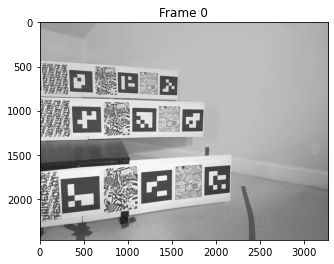

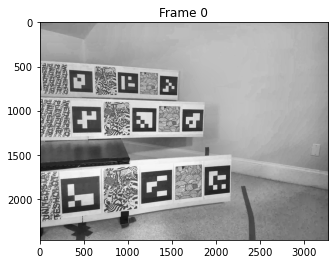

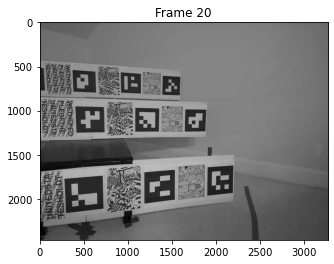

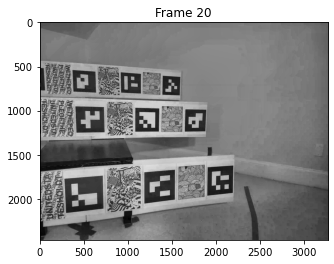

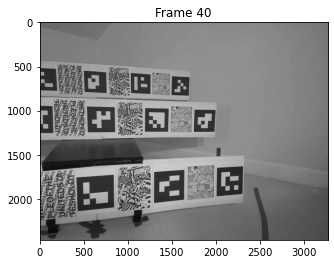

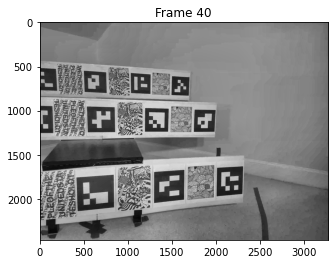

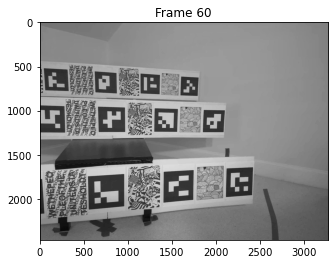

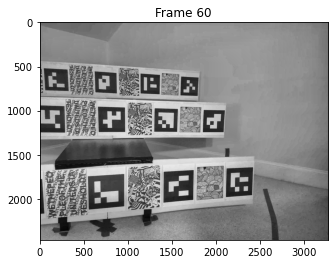

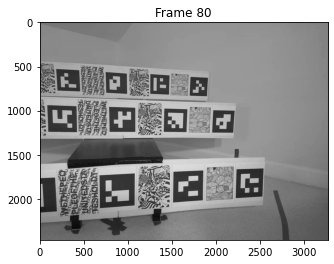

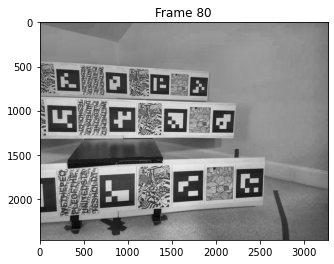

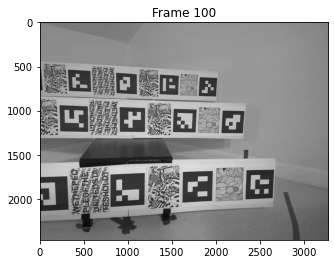

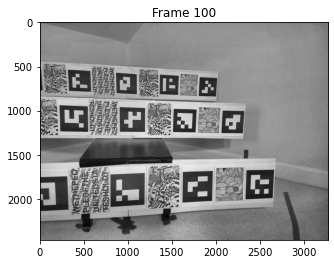

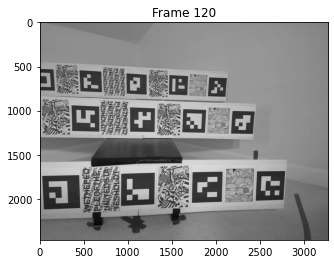

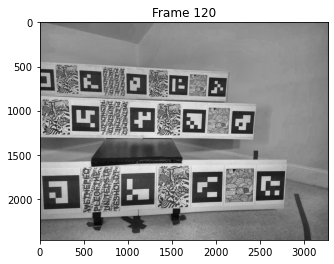

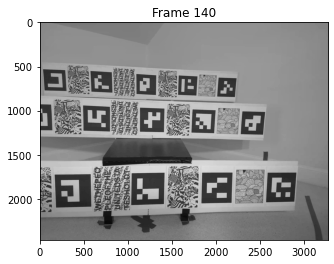

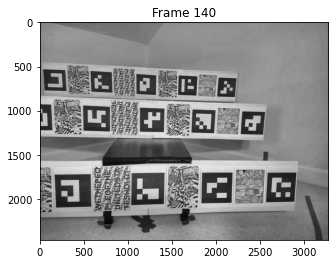

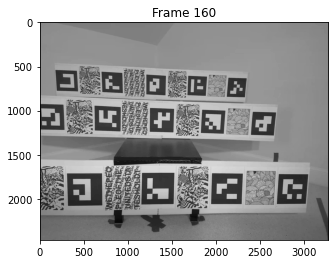

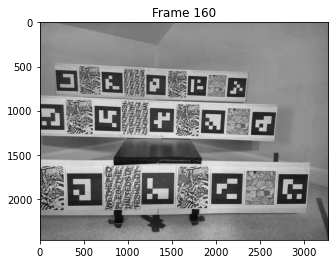

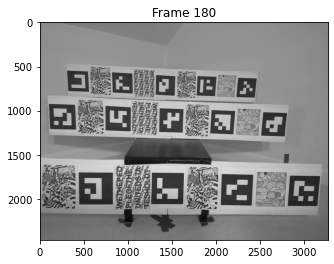

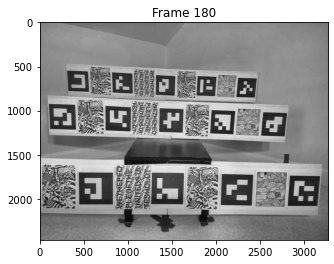

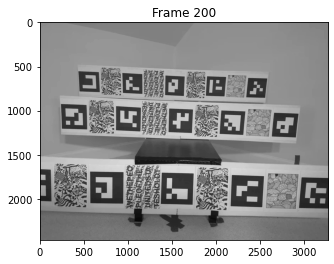

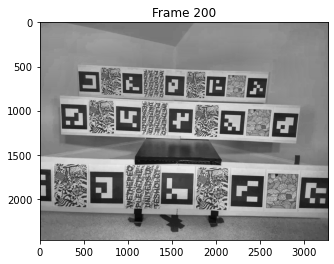

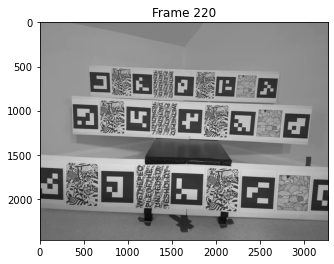

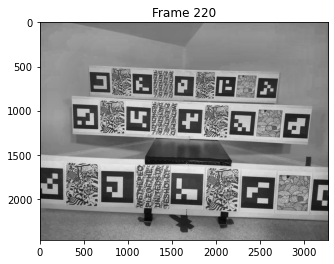

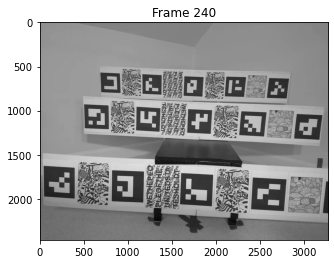

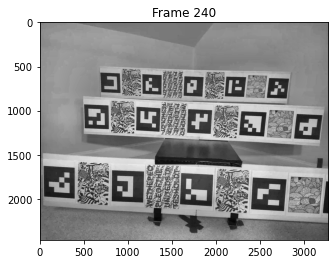

KeyboardInterrupt: 

In [15]:
video_capture = cv2.VideoCapture('{}{}'.format(datadir, video_files[1]))
#video_capture.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'h264'))

video_capture.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'H264'))

frame = 0
while video_capture.isOpened():
    ret, image = video_capture.read()
    
    
    if not ret:
        break
    if frame%20 == 0:
        image2 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        plt.imshow(image2,cmap='gray')
        plt.title('Frame {}'.format(frame))
        plt.show()
        plt.imshow(cv2.cvtColor(increase_contrast(image, clipLimit=2.0, verbose=False), cv2.COLOR_BGR2GRAY),cmap='gray')
        plt.title('Frame {}'.format(frame))
        plt.show()
    frame += 1
print('Done!')

# Run the analysis

In [14]:
# function to find the centers of the optical flow zones
# sometimes an aruco marker may be outside of the view, then extrapolate to find the location
def find_target_centers(sorted_centers, sorted_center_ids):
    front_row = [1,2,3] # the OFZones in the front row are located between aruco id 1 and 2 and 2 and 3
    middle_row = [6,7,8]
    back_row = [11, 12, 13]
    results = []

    rows = [{'row':'front', 'aruco_ids':front_row}, {'row':'middle', 'aruco_ids':middle_row}, {'row':'back', 'aruco_ids':back_row}]

    for row in rows:
        result_row = row.copy()

        aruco_target = row['aruco_ids']
        
        # need to check we have 2 of three aruco_ids per row
        ids_count = 0
        for ids in aruco_target:
            if ids in sorted_center_ids:
                ids_count += 1

        if ids_count > 1:
            if aruco_target[1] in sorted_center_ids:
                if aruco_target[0] in sorted_center_ids:
                    # calc by interpolation
                    target_l = (sorted_centers[np.where(sorted_center_ids==aruco_target[1])] + sorted_centers[np.where(sorted_center_ids==aruco_target[0])])/2
                else:
                    # calc by extrapolation
                    target_l = ( sorted_centers[np.where(sorted_center_ids==aruco_target[1])] -
                     (sorted_centers[np.where(sorted_center_ids==aruco_target[2])] - sorted_centers[np.where(sorted_center_ids==aruco_target[1])])/2)

                if aruco_target[2] in sorted_center_ids:
                    target_r = (sorted_centers[np.where(sorted_center_ids==aruco_target[2])] + sorted_centers[np.where(sorted_center_ids==aruco_target[1])])/2   
                else:
                    target_r = ( sorted_centers[np.where(sorted_center_ids==aruco_target[1])] +
                     (sorted_centers[np.where(sorted_center_ids==aruco_target[1])] - sorted_centers[np.where(sorted_center_ids==aruco_target[0])])/2)
            else:  # we have [0] and [2]
                delta = (sorted_centers[np.where(sorted_center_ids==aruco_target[2])] - sorted_centers[np.where(sorted_center_ids==aruco_target[0])])/4
                
                target_l = sorted_centers[np.where(sorted_center_ids==aruco_target[0])] + delta

                target_r = sorted_centers[np.where(sorted_center_ids==aruco_target[0])] + 3*delta
                
                
            result_row['left_zone_center'] = target_l.reshape(2)
            result_row['right_zone_center'] = target_r.reshape(2)
        
        else:
            result_row['left_zone_center'] = np.array([np.nan,np.nan])
            result_row['right_zone_center'] = np.array([np.nan,np.nan])



        results.append(result_row)
    return results

In [15]:
# remove outliers using statistics 
def clean_OF(of_array, std=2):
    
    of_x = of_array[:,:,0]
    mean_x = np.nanmean(of_x)
    std_x = np.std(of_x)
    
    # create boolean arrays of where the readings are out-of-bounds
    flow_too_large = of_x > mean_x + std*std_x
    flow_too_small = of_x < mean_x - std*std_x

    # create a copy of flow_x
    cleaned_flow_x = of_x.copy()
    # set all the our-of-bound elements to np.NaN
    cleaned_flow_x[np.logical_or(flow_too_large, flow_too_small)] = np.nan

    return cleaned_flow_x

In [16]:
def read_frame(handle, counter):
    counter += 1    
    ret, frame = handle.read()    
    return ret, frame, counter


def get_frame(handle, counter):
    counter += 1
    ret = handle.grab()
    return ret, counter

import math

# Process File with Frame interleave

In [17]:
def read_frame(handle, counter):
    counter += 1    
    ret, frame = handle.read()    
    return ret, frame, counter


def get_frame(handle, counter):
    counter += 1
    ret = handle.grab()
    return ret, counter

import math

In [18]:
#New version that interleaves frames
def process_file2(file_path, 
                 skip_frames=-1,
                 mean_pixels=120, 
                 verbose=0,
                 grabframe=-1):
    
    if skip_frames == -1:
        dynamic_skips = pd.Series([10,10,7,5], index=[0,2,4,6])
    
        rot_vel = abs(int(file_path.split('/')[-1].split('_')[2]))
        skip_frames = dynamic_skips.loc[rot_vel]
        print("Dynamic skip_frames = {} ({})".format(skip_frames, rot_vel))
    else:
        print("skip_frames = {}".format(skip_frames))
    
    result_list = []

    counter = 0
    result_df = pd.DataFrame(columns=['AM0','AM1','AM2','AM3','AM4','AM5','AM6','AM7','AM8','AM9','AM10','AM11','AM12','AM13','AM14',
                                     'OFC0', 'OFC1', 'OFC2', 'OFC3', 'OFC4', 'OFC5',
                                     'OFZ0','OFZ1','OFZ2','OFZ3','OFZ4','OFZ5'])
    
    pics = [] # list to hold copies of the skipped frames
    
    # the size of the square to average the flow over
    center_range = mean_pixels

    cap = cv2.VideoCapture(file_path)
    print("Working with: {}".format(file_path))
    
    # Thresholds to extract the right frames
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    mid = num_frames/2
    lower_bound = max(int(21), int(mid-75)) # drops the first 25% frames
    upper_bound = min(num_frames-21, int(mid+75)) # drops the last 25% second
    print('Frames: {}  mid: {} lower: {} upper: {}'.format(num_frames, mid, lower_bound, upper_bound))

    
    # skip the initial frames
    for _ in range(lower_bound):
        ret, counter = get_frame(cap, counter)
        print('.', end ='')
    
    # initialize the pics list with frames
    
    # Get first frame
    ret, frame0, counter = read_frame(cap, counter)
    frame0_color = cv2.undistort(frame0,cam_calOF['mtx'],cam_calOF['dist'],None)
    frame0_gray = cv2.cvtColor(frame0_color,cv2.COLOR_BGR2GRAY)
    pics.append(frame0_gray)
    
    # initialze the array of flows
    flow = np.zeros_like(frame0)
    flags = 0
    
    for i in range(skip_frames-1):
        # read the frames
        ret, frame1, counter = read_frame(cap, counter)
        current_pic_color = cv2.undistort(frame1,cam_calOF['mtx'],cam_calOF['dist'],None)
        current_pic_gray = cv2.cvtColor(current_pic_color,cv2.COLOR_BGR2GRAY)
        pics.append(current_pic_gray)  

        flow = cv2.calcOpticalFlowFarneback(pics[0], current_pic_gray, flow, 0.5, 3, 50, 6, 7, 1.5, flags)
        flags = cv2.OPTFLOW_USE_INITIAL_FLOW

        

    # this creates the array for the sorted centers 
    sorted_centers = np.zeros([10,2])
    


    while(counter < upper_bound):
        
        # read a frame
        ret, curr_pic_color, counter = read_frame(cap, counter)

        curr_pic_color = cv2.undistort(curr_pic_color,cam_calOF['mtx'],cam_calOF['dist'],None)
        curr_pic_grey = cv2.cvtColor(curr_pic_color, cv2.COLOR_BGR2GRAY)

        #flow[:,:,1] = 0


        flow = cv2.calcOpticalFlowFarneback(pics[0], curr_pic_grey, flow, 0.5, 3, 50, 6, 7, 1.5, flags)

        if verbose>0:
            print('Image Frame Number: {}'.format(counter))


        # find the four corners of each aruco marker
        arucoCorners, arucoIds, imsize =  find_charuco_marker_corners(curr_pic_color, 
                                                            aruco_dict, clipLimit=2.0, 
                                                            verbose=False)

        # now find the center point of each aruco marker 
        centers, center_ids = find_aruco_center(arucoCorners, arucoIds)

        # next sort the centers by center_ids from 0 to 9
        center_ids = center_ids.reshape(-1)
        centers = centers.reshape(-1,2)
        if verbose>1:  
            print('CenterIds {}'.format(center_ids))

        # insert the centers into the sorted centers array in the right order
        arr1inds = center_ids.argsort()
        sorted_centers = centers[arr1inds]
        sorted_center_ids = center_ids[arr1inds] 
        
        # add sorted centers to the frame results series
        frame_res = pd.Series(index=['AM0','AM1','AM2','AM3','AM4','AM5','AM6','AM7','AM8','AM9','AM10','AM11','AM12','AM13','AM14',
                                     'OFC0', 'OFC1', 'OFC2', 'OFC3', 'OFC4', 'OFC5',
                                     'OFZ0','OFZ1','OFZ2','OFZ3','OFZ4','OFZ5' ], dtype=object)
        
        # save the aruco marker centers to the series
        for ind, ids in enumerate(sorted_center_ids):
            frame_res['AM{}'.format(ids)] = sorted_centers[ind]
            
        frame_result_list = []
        
        # find the centers of all the target zones
        targets = find_target_centers(sorted_centers, sorted_center_ids)
        """
        {'row': 'front',
          'aruco_ids': [1, 2, 3],
          'left_zone_center': array([2208.1284, 2125.8706], dtype=float32),
          'right_zone_center': array([3100.6724, 2243.5234], dtype=float32)}
          """
        of_zone_number = 0
        
        for row in targets:
            frame_res['OFC{}'.format(of_zone_number)] = row['left_zone_center']
            frame_res['OFZ{}'.format(of_zone_number)] = 777 #get_cleaned_OF(flow, center, pixels)

            of_zone_number += 1       
            
            frame_res['OFC{}'.format(of_zone_number)] = row['right_zone_center']
            frame_res['OFZ{}'.format(of_zone_number)] = 777 #get_cleaned_OF(flow, center, pixels)

            of_zone_number += 1


        
        
        # extract the optical flow in the areas around the target zones
        for of_center in frame_res[frame_res.index.str.contains('OFC')].index:
            center = frame_res[of_center]
            
            if verbose>1:
                print('OFCenter {} : {} - flow.shape {}'.format(of_center, center, flow.shape))
            
            center_x = center[0]
            center_y = center[1]
            
            if not (math.isnan(center_x) or math.isnan(center_y)):
                sub_OF_array = flow[int(center_y-mean_pixels/2):int(center_y+mean_pixels/2), 
                                    int(center_x-mean_pixels/2):int(center_x+mean_pixels/2), :]
                

                # extract x component of OF and clean the optical flow 
                cleaned_of_x = clean_OF(sub_OF_array, std=2)

                # find the mean of the optical flow in x and y
                mean_of_x = np.nanmean(cleaned_of_x)/skip_frames


                # save the results in a df

                frame_res['OFZ{}'.format(of_center[3:])] = mean_of_x
            else: 
                print('WARNING: Nan OF center')
                frame_res['OFZ{}'.format(of_center[3:])] = np.nan
        
        if verbose>0:
            print(frame_res) 
            print('Skip frame length: {}'.format(len(pics)))


        result_df.loc[counter] = frame_res

        if verbose>1:
            
            hsv = np.zeros_like(frame1)
            hsv[...,1] = 255


            x = sorted_centers[:,0]
            y = sorted_centers[:,1]
            mag = (cv2.multiply(cv2.add(flow[...,0],-10),5))

            mag[mag<0.0] = 0
            mag[mag>255] = 255

            print("mean: {} max: {}  min: {} {}".format(mag.mean(), mag.max(), mag.min(), flow.shape))

            # edge detection for the outlines
            edges = cv2.Canny(curr_pic_color, 50, 100)


            hsv[...,0] = 0
            #hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
            hsv[...,2] = mag
            rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

            annot_font = {'fontname':'Arial', 'size':'14','weight':'bold'}

            fig, axs = plt.subplots(figsize=(36,24))
            rgb[edges>100,1] = 255 
            axs.imshow(rgb)
            axs.scatter(x,y, color='r')
            for i, ids in enumerate(sorted_center_ids):
                axs.annotate('{}'.format(int(ids)), (x[i]+20, y[i]+30), color='r',  **annot_font)
                
            for ind in frame_res[frame_res.index.str.contains('OFC')].index:
                axs.annotate('{}'.format(ind), frame_res[ind], color='w', **annot_font)

            plt.show()
            
            if counter == grabframe:  # this is a hack to save a particular image set
                save_dict = {}
                save_dict['filename'] = file_path
                save_dict['frame'] = counter
                save_dict['img'] = curr_pic_grey

                save_dict['flow'] = flow

                save_dict['centers'] = sorted_centers

                save_dict['center_ids'] = sorted_center_ids

                save_dict['frame_res'] = frame_res


                pickle.dump(save_dict, open('{}frame_results.p'.format(datadir), 'wb'))
                
        pics.append(curr_pic_grey) # add the current image to end
        
        # cycle the stored frames
        for i in range(skip_frames):
            pics[i] = np.copy(pics[i+1])
        pics.pop(-1) # remove the last item
        
        
        
    #pickle.dump(result_df, open('{}{}_res.p'.format(datadir, file[:-5]), 'wb'))
    return result_df

In [19]:
frame_res = pd.Series(index=['AM0','AM1','AM2','AM3','AM4','AM5','AM6','AM7','AM8','AM9','AM10','AM11','AM12','AM13','AM14',
                                     'OFC0', 'OFC1', 'OFC2', 'OFC3', 'OFC4', 'OFC5',
                                     'OFZ0','OFZ1','OF20','OFZ3','OFZ4','OFZ5' ], dtype=object)

In [20]:
video_files

array(['Smooth_15_-2_0_4623HF.mp4', 'Smooth_15_-2_1_QV4WNZ.mp4',
       'Smooth_15_-2_2_JB90U4.mp4', 'Smooth_15_-2_3_MCDNNA.mp4',
       'Smooth_15_-2_4_VIWO2O.mp4', 'Smooth_15_-4_0_ESS22N.mp4',
       'Smooth_15_-4_1_8GD6QO.mp4', 'Smooth_15_-4_2_FMBNMX.mp4',
       'Smooth_15_-4_3_EEUONU.mp4', 'Smooth_15_-4_4_64CXH3.mp4',
       'Smooth_15_-6_0_2HDNNZ.mp4', 'Smooth_15_-6_1_D23FV7.mp4',
       'Smooth_15_-6_2_U8BJY4.mp4', 'Smooth_15_-6_3_GK86VH.mp4',
       'Smooth_15_-6_4_JU8DFH.mp4', 'Smooth_15_0_0_D26LA1.mp4',
       'Smooth_15_0_1_OOBKBZ.mp4', 'Smooth_15_0_2_MNBSLT.mp4',
       'Smooth_15_0_3_VY12DF.mp4', 'Smooth_15_0_4_46CIDO.mp4',
       'Smooth_30_-2_0_07HKRJ.mp4', 'Smooth_30_-2_1_UA678T.mp4',
       'Smooth_30_-2_2_Z2CEPT.mp4', 'Smooth_30_-2_3_DPNF63.mp4',
       'Smooth_30_-2_4_O2G6SZ.mp4', 'Smooth_30_-4_0_9WKFQF.mp4',
       'Smooth_30_-4_1_B6QVWT.mp4', 'Smooth_30_-4_2_9YG7KZ.mp4',
       'Smooth_30_-4_3_ZZ3YEH.mp4', 'Smooth_30_-4_4_ARXESZ.mp4',
       'Smooth_30_-6_0_HOA2A3.

In [22]:
# set verbose = True to make plots of each frame
verbose = 1

for file in video_files[70:]: #video_files:
    res = process_file2(datadir+file, mean_pixels=120, verbose=verbose, skip_frames=-1)
    pickle.dump(res, open('{}{}_res4.p'.format(datadir, file[:-4]), 'wb'))

Dynamic skip_frames = 5 (6)
Working with: /Users/gerrie/Google Drive/ScienceFair2021/DataCapture/smooth/Smooth_60_-6_0_EO5Q0F.mp4
Frames: 130  mid: 65.0 lower: 21 upper: 109
.....................Image Frame Number: 27
AM0                        NaN
AM1                        NaN
AM2     [635.35693, 1923.3663]
AM3     [1452.8136, 1858.4379]
AM4      [2137.0183, 1803.583]
AM5                        NaN
AM6                        NaN
AM7     [704.65753, 1110.2543]
AM8      [1318.6204, 1113.857]
AM9     [1860.4641, 1122.8102]
AM10                       NaN
AM11                       NaN
AM12      [649.2719, 696.2053]
AM13    [1147.1609, 708.40784]
AM14     [1590.8784, 732.5425]
OFC0     [226.6286, 1955.8306]
OFC1    [1044.0852, 1890.9021]
OFC2    [397.67612, 1108.4529]
OFC3    [1011.6389, 1112.0557]
OFC4    [400.32742, 690.10406]
OFC5     [898.21643, 702.3066]
OFZ0                   21.4634
OFZ1                   17.6105
OFZ2                   19.6331
OFZ3                    17.141
OFZ4   

Image Frame Number: 36
AM0                        NaN
AM1                        NaN
AM2     [810.56946, 1906.4362]
AM3     [1609.6432, 1859.0161]
AM4     [2295.8462, 1816.6471]
AM5                        NaN
AM6     [204.72443, 1104.9807]
AM7     [874.60284, 1110.1143]
AM8     [1471.8838, 1116.7253]
AM9     [2011.9241, 1129.0417]
AM10                       NaN
AM11     [279.89713, 675.5977]
AM12       [817.5466, 703.443]
AM13     [1300.9132, 714.6388]
AM14     [1738.762, 737.90497]
OFC0     [411.0326, 1930.1462]
OFC1    [1210.1063, 1882.7261]
OFC2    [539.66364, 1107.5475]
OFC3    [1173.2433, 1113.4198]
OFC4     [548.72186, 689.5204]
OFC5     [1059.2299, 709.0409]
OFZ0                   21.5329
OFZ1                   18.2641
OFZ2                   20.2189
OFZ3                   17.7724
OFZ4                   19.7078
OFZ5                   17.6585
dtype: object
Skip frame length: 5
Image Frame Number: 37
AM0                        NaN
AM1                        NaN
AM2      [829.22784,

Image Frame Number: 46
AM0                        NaN
AM1                        NaN
AM2        [997.655, 1893.433]
AM3     [1779.6826, 1863.2657]
AM4       [2472.9968, 1834.99]
AM5                        NaN
AM6      [412.5469, 1102.0114]
AM7     [1051.3676, 1110.8989]
AM8      [1637.0348, 1121.231]
AM9     [2178.9563, 1136.8634]
AM10                       NaN
AM11      [477.6716, 684.0983]
AM12    [990.93335, 710.29285]
AM13     [1463.3057, 720.5704]
AM14     [1899.0869, 743.0085]
OFC0    [606.64124, 1908.5166]
OFC1    [1388.6688, 1878.3494]
OFC2     [731.9572, 1106.4551]
OFC3     [1344.2012, 1116.065]
OFC4     [734.3025, 697.19556]
OFC5    [1227.1195, 715.43164]
OFZ0                   19.3419
OFZ1                   17.0514
OFZ2                   18.2738
OFZ3                   16.5715
OFZ4                   17.7976
OFZ5                    16.301
dtype: object
Skip frame length: 5
Image Frame Number: 47
AM0                        NaN
AM1                        NaN
AM2     [1019.2037, 

Image Frame Number: 56
AM0                        NaN
AM1     [343.93576, 1907.2871]
AM2     [1177.4312, 1885.4553]
AM3     [1951.5254, 1871.9675]
AM4      [2657.287, 1857.8351]
AM5                        NaN
AM6     [608.91406, 1100.4971]
AM7     [1223.5903, 1112.8713]
AM8     [1802.5884, 1126.7639]
AM9     [2350.5142, 1145.8213]
AM10                       NaN
AM11    [667.09033, 692.48517]
AM12     [1162.2723, 717.4313]
AM13     [1626.1995, 726.4214]
AM14    [2062.9023, 748.02405]
OFC0     [760.6835, 1896.3712]
OFC1    [1564.4783, 1878.7114]
OFC2     [916.2522, 1106.6842]
OFC3    [1513.0894, 1119.8176]
OFC4    [914.68134, 704.95825]
OFC5    [1394.2358, 721.92633]
OFZ0                   18.7115
OFZ1                   17.0086
OFZ2                   17.6644
OFZ3                   16.5365
OFZ4                   17.2999
OFZ5                   16.1816
dtype: object
Skip frame length: 5
Image Frame Number: 57
AM0                        NaN
AM1      [364.6894, 1905.0381]
AM2      [1194.7891,

Image Frame Number: 66
AM0                        NaN
AM1     [555.98376, 1885.6521]
AM2      [1358.772, 1882.2728]
AM3     [2131.6765, 1886.4128]
AM4      [2857.275, 1887.3219]
AM5                        NaN
AM6      [799.8803, 1100.6238]
AM7     [1398.1898, 1116.2286]
AM8     [1974.4211, 1133.8037]
AM9      [2533.394, 1157.0947]
AM10     [354.64743, 683.9815]
AM11     [851.64087, 700.3782]
AM12     [1332.2542, 723.9669]
AM13     [1792.4092, 731.8605]
AM14       [2233.4788, 752.99]
OFC0    [957.37787, 1883.9624]
OFC1    [1745.2242, 1884.3428]
OFC2     [1099.035, 1108.4263]
OFC3    [1686.3054, 1125.0161]
OFC4    [1091.9475, 712.17255]
OFC5     [1562.3317, 727.9137]
OFZ0                   18.3035
OFZ1                   17.3659
OFZ2                   17.2082
OFZ3                    16.675
OFZ4                   16.7951
OFZ5                   16.1272
dtype: object
Skip frame length: 5
Image Frame Number: 67
AM0                        NaN
AM1     [575.24384, 1884.6067]
AM2     [1375.6151, 

Image Frame Number: 76
AM0                        NaN
AM1      [747.1532, 1871.2686]
AM2     [1531.7162, 1884.3079]
AM3       [2308.98, 1904.6362]
AM4                        NaN
AM5      [380.0958, 1081.5991]
AM6      [977.6966, 1101.8907]
AM7      [1563.6716, 1120.939]
AM8     [2143.2913, 1142.1274]
AM9     [2717.0103, 1169.4801]
AM10     [545.90515, 692.2483]
AM11    [1023.85046, 707.3343]
AM12    [1495.2537, 729.51294]
AM13    [1953.8179, 736.04175]
AM14     [2403.7275, 757.6086]
OFC0    [1139.4347, 1877.7882]
OFC1     [1920.3481, 1894.472]
OFC2    [1270.6841, 1111.4148]
OFC3    [1853.4814, 1131.5332]
OFC4      [1259.552, 718.4236]
OFC5    [1724.5358, 732.77734]
OFZ0                   17.6032
OFZ1                   17.4063
OFZ2                    16.804
OFZ3                   16.7009
OFZ4                   16.4034
OFZ5                      16.1
dtype: object
Skip frame length: 5
Image Frame Number: 77
AM0                        NaN
AM1      [766.67633, 1869.972]
AM2     [1548.5829, 

Image Frame Number: 86
AM0      [177.41138, 1819.367]
AM1     [935.29065, 1861.2472]
AM2      [1708.606, 1891.1086]
AM3     [2498.6707, 1928.8777]
AM4                        NaN
AM5      [579.1855, 1080.9808]
AM6     [1154.6304, 1104.1577]
AM7     [1734.4082, 1126.6411]
AM8     [2322.1943, 1151.9849]
AM9     [2916.0012, 1184.2875]
AM10     [733.0421, 699.99786]
AM11     [1196.3619, 714.0822]
AM12    [1661.9752, 735.05457]
AM13     [2125.0183, 741.3839]
AM14     [2585.3618, 762.3298]
OFC0     [1321.9482, 1876.178]
OFC1    [2103.6382, 1909.9932]
OFC2    [1444.5193, 1115.3994]
OFC3     [2028.3013, 1139.313]
OFC4    [1429.1686, 724.56836]
OFC5    [1893.4968, 738.21924]
OFZ0                   18.2047
OFZ1                   18.7641
OFZ2                   17.5447
OFZ3                   17.8695
OFZ4                   17.0429
OFZ5                   17.1145
dtype: object
Skip frame length: 5
Image Frame Number: 87
AM0     [187.10422, 1816.3081]
AM1       [952.707, 1860.5974]
AM2     [1723.5896, 

Image Frame Number: 96
AM0     [368.68472, 1800.1183]
AM1     [1115.0203, 1856.1398]
AM2     [1880.9685, 1903.1421]
AM3     [2691.5151, 1958.4471]
AM4                        NaN
AM5     [761.43665, 1081.7906]
AM6     [1322.4786, 1107.9036]
AM7     [1902.1523, 1133.3491]
AM8     [2501.3945, 1163.3271]
AM9                        NaN
AM10    [907.61884, 707.40356]
AM11     [1361.0138, 720.0108]
AM12     [1823.6333, 740.1587]
AM13     [2293.809, 745.94385]
AM14      [2769.196, 767.1628]
OFC0    [1497.9944, 1879.6409]
OFC1    [2286.2417, 1930.7947]
OFC2    [1612.3154, 1120.6263]
OFC3    [2201.7734, 1148.3381]
OFC4     [1592.3235, 730.0847]
OFC5     [2058.7212, 743.0513]
OFZ0                     16.98
OFZ1                   18.1929
OFZ2                   16.3548
OFZ3                   17.1573
OFZ4                   15.9203
OFZ5                   16.3178
dtype: object
Skip frame length: 5
Image Frame Number: 97
AM0     [389.86182, 1798.3937]
AM1     [1134.0717, 1856.5339]
AM2       [1900.374,

Image Frame Number: 106
AM0     [563.03955, 1786.6068]
AM1      [1287.634, 1856.6555]
AM2     [2056.8298, 1919.4784]
AM3     [2896.3982, 1994.6254]
AM4                        NaN
AM5     [937.84937, 1083.7755]
AM6     [1489.2007, 1112.7272]
AM7     [2071.2048, 1142.5382]
AM8     [2688.6528, 1176.6455]
AM9                        NaN
AM10      [1076.877, 713.9335]
AM11     [1522.1631, 725.6306]
AM12     [1987.8633, 745.0547]
AM13    [2469.3015, 750.64185]
AM14     [2962.8208, 772.0084]
OFC0    [1672.2319, 1888.0669]
OFC1     [2476.614, 1957.0519]
OFC2    [1780.2028, 1127.6327]
OFC3    [2379.9287, 1159.5918]
OFC4    [1755.0132, 735.34265]
OFC5    [2228.5825, 747.84827]
OFZ0                   17.1277
OFZ1                   18.9933
OFZ2                   16.6668
OFZ3                   18.0145
OFZ4                   16.2005
OFZ5                   16.9645
dtype: object
Skip frame length: 5
Image Frame Number: 107
AM0      [581.7235, 1785.3667]
AM1     [1304.7085, 1856.7383]
AM2     [2076.0054

Image Frame Number: 32
AM0                        NaN
AM1                        NaN
AM2      [736.6404, 1913.7251]
AM3         [1542.25, 1857.75]
AM4     [2227.2358, 1810.6826]
AM5                        NaN
AM6                        NaN
AM7     [802.79974, 1109.9089]
AM8     [1405.6095, 1115.7211]
AM9     [1946.1907, 1126.3203]
AM10                       NaN
AM11    [195.24826, 671.17114]
AM12     [746.2521, 700.66266]
AM13     [1233.9523, 712.5712]
AM14    [1675.1879, 735.75275]
OFC0    [333.83557, 1941.7126]
OFC1    [1139.4452, 1885.7375]
OFC2    [501.39487, 1107.0029]
OFC3     [1104.2046, 1112.815]
OFC4     [470.75018, 685.9169]
OFC5     [990.1022, 706.61694]
OFZ0                   20.7386
OFZ1                   17.3576
OFZ2                   19.0534
OFZ3                   16.7987
OFZ4                   18.8131
OFZ5                   16.7148
dtype: object
Skip frame length: 5
Image Frame Number: 33
AM0                        NaN
AM1                        NaN
AM2     [757.01013, 

Image Frame Number: 42
AM0                        NaN
AM1                        NaN
AM2     [931.37634, 1897.5594]
AM3     [1718.0636, 1861.2572]
AM4     [2407.6948, 1828.0354]
AM5                        NaN
AM6     [339.52145, 1102.9294]
AM7     [989.28894, 1110.3013]
AM8     [1577.0868, 1119.7384]
AM9      [2117.473, 1133.9209]
AM10                       NaN
AM11      [407.89197, 681.091]
AM12      [929.9592, 708.4827]
AM13     [1405.1622, 718.7144]
AM14     [1842.0513, 741.3136]
OFC0     [538.0327, 1915.7106]
OFC1      [1324.72, 1879.4083]
OFC2     [664.4052, 1106.6154]
OFC3    [1283.1879, 1115.0198]
OFC4     [668.9256, 694.78687]
OFC5     [1167.5608, 713.5986]
OFZ0                   20.3305
OFZ1                   17.6667
OFZ2                   19.1695
OFZ3                   17.1957
OFZ4                   18.7357
OFZ5                   16.9973
dtype: object
Skip frame length: 5
Image Frame Number: 43
AM0                         NaN
AM1                         NaN
AM2       [947.491

Image Frame Number: 52
AM0                        NaN
AM1     [267.74997, 1916.9464]
AM2     [1113.6539, 1887.8546]
AM3     [1888.8676, 1868.5527]
AM4     [2589.5615, 1849.1476]
AM5                        NaN
AM6      [538.7864, 1101.0808]
AM7     [1161.7925, 1112.4781]
AM8      [1742.4955, 1124.826]
AM9     [2287.2993, 1142.5674]
AM10                       NaN
AM11    [598.84937, 690.10004]
AM12     [1101.3187, 715.2641]
AM13     [1567.2241, 724.5796]
AM14     [2003.2339, 746.4966]
OFC0    [690.70197, 1902.4005]
OFC1    [1501.2607, 1878.2036]
OFC2     [850.2894, 1106.7795]
OFC3     [1452.144, 1118.6521]
OFC4    [850.08405, 702.68207]
OFC5     [1334.2715, 719.9219]
OFZ0                   18.7736
OFZ1                   16.8158
OFZ2                   17.6431
OFZ3                   16.3517
OFZ4                   17.3176
OFZ5                   16.0251
dtype: object
Skip frame length: 5
Image Frame Number: 53
AM0                        NaN
AM1     [290.56165, 1914.1263]
AM2     [1132.5502, 

Image Frame Number: 62
AM0                        NaN
AM1     [480.57288, 1893.6895]
AM2      [1292.0312, 1883.051]
AM3     [2063.5193, 1880.6941]
AM4     [2781.3687, 1875.4661]
AM5                        NaN
AM6      [730.92017, 1100.495]
AM7          [1333.75, 1115.0]
AM8      [1910.938, 1131.1735]
AM9     [2464.9834, 1153.0234]
AM10     [278.1912, 680.24493]
AM11      [784.9829, 697.6393]
AM12     [1270.5652, 722.1813]
AM13    [1731.6487, 730.13055]
AM14     [2170.2095, 751.3167]
OFC0    [886.30206, 1888.3702]
OFC1    [1677.7753, 1881.8726]
OFC2    [1032.3351, 1107.7476]
OFC3     [1622.344, 1123.0867]
OFC4      [1027.774, 709.9103]
OFC5     [1501.1069, 726.1559]
OFZ0                   18.9335
OFZ1                   17.6894
OFZ2                   18.0492
OFZ3                   17.2559
OFZ4                   17.7507
OFZ5                   16.8292
dtype: object
Skip frame length: 5
Image Frame Number: 63
AM0                        NaN
AM1     [500.19385, 1891.9469]
AM2          [1309.0

Image Frame Number: 72
AM0                        NaN
AM1     [679.61035, 1876.0793]
AM2     [1470.0067, 1883.1167]
AM3     [2244.8875, 1897.6273]
AM4      [2988.079, 1909.0873]
AM5     [308.81705, 1081.9272]
AM6     [915.08923, 1101.4609]
AM7     [1504.3926, 1119.2292]
AM8     [2082.6829, 1139.1893]
AM9     [2650.1428, 1164.9723]
AM10      [480.4765, 689.6278]
AM11    [963.07245, 704.96606]
AM12    [1437.2439, 727.81085]
AM13    [1896.5223, 735.06824]
AM14     [2342.317, 756.01294]
OFC0     [1074.8086, 1879.598]
OFC1     [1857.447, 1890.3721]
OFC2     [1209.741, 1110.3451]
OFC3    [1793.5377, 1129.2092]
OFC4     [1200.1582, 716.3884]
OFC5      [1666.883, 731.4396]
OFZ0                   18.1912
OFZ1                   17.7194
OFZ2                   17.1674
OFZ3                   16.8983
OFZ4                   16.6827
OFZ5                   16.2987
dtype: object
Skip frame length: 5
Image Frame Number: 73
AM0                        NaN
AM1      [698.6436, 1874.6958]
AM2     [1488.0166, 

Image Frame Number: 82
AM0                        NaN
AM1      [864.14294, 1864.687]
AM2     [1639.7893, 1887.9235]
AM3     [2425.8076, 1919.0862]
AM4                        NaN
AM5      [503.7436, 1081.1704]
AM6     [1087.0898, 1103.4979]
AM7       [1668.19, 1124.3999]
AM8     [2252.4473, 1148.2175]
AM9       [2837.38, 1178.4371]
AM10       [661.1607, 697.211]
AM11           [1130.0, 711.5]
AM12      [1596.978, 733.1111]
AM13     [2058.6125, 739.9082]
AM14     [2513.9622, 760.6231]
OFC0    [1251.9661, 1876.3052]
OFC1    [2032.7985, 1903.5049]
OFC2     [1377.6399, 1113.949]
OFC3    [1960.3186, 1136.3087]
OFC4     [1363.489, 722.30554]
OFC5    [1827.7953, 736.50964]
OFZ0                   17.1849
OFZ1                   17.4268
OFZ2                   16.4425
OFZ3                   16.6114
OFZ4                   16.0044
OFZ5                   15.9071
dtype: object
Skip frame length: 5
Image Frame Number: 83
AM0                        NaN
AM1      [884.2405, 1863.7234]
AM2     [1657.9902, 

Image Frame Number: 92
AM0       [293.9518, 1807.125]
AM1     [1049.6567, 1857.7798]
AM2     [1818.6625, 1898.7253]
AM3     [2619.9517, 1947.0775]
AM4                        NaN
AM5     [696.10315, 1081.5817]
AM6     [1261.6641, 1106.7704]
AM7     [1840.5382, 1131.4255]
AM8     [2435.7026, 1159.1755]
AM9     [3045.4968, 1194.9182]
AM10      [845.0463, 704.9499]
AM11     [1301.4897, 718.0179]
AM12     [1764.9934, 738.5874]
AM13      [2232.4954, 744.597]
AM14    [2700.5254, 765.91455]
OFC0    [1434.1597, 1878.2526]
OFC1    [2219.3071, 1922.9014]
OFC2    [1551.1011, 1119.0979]
OFC3    [2138.1204, 1145.3005]
OFC4     [1533.2416, 728.3026]
OFC5    [1998.7444, 741.59216]
OFZ0                   17.5048
OFZ1                   18.4764
OFZ2                   16.9222
OFZ3                   17.5672
OFZ4                   16.4508
OFZ5                   16.6821
dtype: object
Skip frame length: 5
Image Frame Number: 93
AM0      [312.5328, 1805.2935]
AM1     [1066.8734, 1857.6179]
AM2      [1833.5415,

Image Frame Number: 102
AM0      [493.95374, 1791.283]
AM1       [1226.67, 1856.0508]
AM2     [1993.7781, 1913.5892]
AM3     [2820.4617, 1980.7345]
AM4                        NaN
AM5      [874.6058, 1083.1365]
AM6     [1428.9698, 1110.9749]
AM7     [2009.8157, 1139.1505]
AM8     [2619.6243, 1171.8926]
AM9                        NaN
AM10    [1015.7065, 711.69574]
AM11     [1463.8865, 723.8084]
AM12     [1927.9155, 743.4203]
AM13    [2404.8457, 749.21655]
AM14    [2890.9502, 770.22986]
OFC0    [1610.2241, 1884.8201]
OFC1    [2407.1199, 1947.1619]
OFC2    [1719.3928, 1125.0627]
OFC3      [2314.72, 1155.5215]
OFC4      [1695.901, 733.6144]
OFC5     [2166.3806, 746.3184]
OFZ0                   16.9718
OFZ1                    18.591
OFZ2                   16.3766
OFZ3                   17.5044
OFZ4                    15.937
OFZ5                   16.5242
dtype: object
Skip frame length: 5
Image Frame Number: 103
AM0     [514.45276, 1789.8905]
AM1     [1245.0948, 1856.3137]
AM2      [2012.637

Image Frame Number: 28
AM0                        NaN
AM1                        NaN
AM2     [668.18066, 1920.1758]
AM3     [1482.4744, 1858.3875]
AM4      [2166.121, 1805.8868]
AM5                        NaN
AM6                        NaN
AM7     [736.53217, 1110.4457]
AM8     [1346.2155, 1114.7046]
AM9     [1888.0175, 1124.0088]
AM10                       NaN
AM11                       NaN
AM12     [680.7453, 697.90405]
AM13     [1175.4312, 709.8906]
AM14     [1618.4575, 733.7221]
OFC0       [261.0338, 1951.07]
OFC1    [1075.3275, 1889.2816]
OFC2    [431.69052, 1108.3162]
OFC3    [1041.3738, 1112.5752]
OFC4    [433.40237, 691.91077]
OFC5    [928.08826, 703.89734]
OFZ0                   21.6448
OFZ1                   17.8633
OFZ2                   19.7069
OFZ3                   17.2603
OFZ4                   18.7219
OFZ5                   17.1829
dtype: object
Skip frame length: 5
Image Frame Number: 29
AM0                        NaN
AM1                        NaN
AM2     [687.37994, 

Image Frame Number: 38
AM0                        NaN
AM1                        NaN
AM2       [859.713, 1902.9502]
AM3     [1652.3071, 1859.7118]
AM4      [2339.779, 1821.1658]
AM5                        NaN
AM6      [258.6134, 1104.9102]
AM7      [918.56256, 1110.508]
AM8     [1512.3934, 1118.0519]
AM9     [2052.6538, 1131.2041]
AM10                       NaN
AM11    [329.19135, 677.65826]
AM12      [861.2789, 705.8181]
AM13    [1340.8867, 716.52264]
AM14    [1778.8984, 739.45575]
OFC0    [463.41595, 1924.5693]
OFC1       [1256.01, 1881.331]
OFC2      [588.588, 1107.7091]
OFC3       [1215.478, 1114.28]
OFC4     [595.2351, 691.73816]
OFC5     [1101.0828, 711.1704]
OFZ0                   20.3528
OFZ1                   17.4607
OFZ2                    19.198
OFZ3                   17.0111
OFZ4                   18.7839
OFZ5                   16.9172
dtype: object
Skip frame length: 5
Image Frame Number: 39
AM0                        NaN
AM1                        NaN
AM2      [879.3571, 

Image Frame Number: 48
AM0                        NaN
AM1                        NaN
AM2     [1047.7015, 1891.0822]
AM3     [1826.0472, 1865.5234]
AM4      [2522.906, 1841.2058]
AM5                        NaN
AM6     [468.44287, 1101.5488]
AM7      [1099.016, 1111.7246]
AM8     [1682.3414, 1122.9414]
AM9     [2225.1887, 1139.6318]
AM10                       NaN
AM11      [531.3616, 687.1199]
AM12     [1039.6543, 713.1012]
AM13    [1508.8806, 722.66907]
AM14     [1944.2455, 744.7628]
OFC0     [658.5287, 1903.8616]
OFC1    [1436.8744, 1878.3027]
OFC2    [783.72943, 1106.6367]
OFC3     [1390.6787, 1117.333]
OFC4    [785.50793, 700.11053]
OFC5    [1274.2675, 717.88513]
OFZ0                   20.0126
OFZ1                   17.8144
OFZ2                   18.9126
OFZ3                   17.3083
OFZ4                   18.4572
OFZ5                   16.9307
dtype: object
Skip frame length: 5
Image Frame Number: 49
AM0                        NaN
AM1     [215.53198, 1924.7499]
AM2      [1064.2605,

Image Frame Number: 58
AM0                        NaN
AM1      [399.89774, 1901.493]
AM2     [1224.9728, 1884.0607]
AM3     [1997.4423, 1876.0033]
AM4     [2708.7192, 1865.2119]
AM5                        NaN
AM6     [659.21405, 1100.8217]
AM7      [1269.3315, 1114.161]
AM8     [1847.1104, 1128.6313]
AM9     [2397.4836, 1148.8469]
AM10     [199.83095, 676.6699]
AM11      [715.7508, 694.8545]
AM12      [1207.336, 719.4843]
AM13    [1669.2877, 728.07385]
AM14     [2107.1309, 749.6903]
OFC0    [812.43524, 1892.7769]
OFC1     [1611.2075, 1880.032]
OFC2     [964.2728, 1107.4913]
OFC3     [1558.221, 1121.3962]
OFC4    [961.54346, 707.16943]
OFC5    [1438.3119, 723.77905]
OFZ0                    18.567
OFZ1                   17.0603
OFZ2                   17.4171
OFZ3                   16.4643
OFZ4                    17.057
OFZ5                   16.0579
dtype: object
Skip frame length: 5
Image Frame Number: 59
AM0                        NaN
AM1      [424.5011, 1899.1155]
AM2     [1245.4028, 

Image Frame Number: 68
AM0                        NaN
AM1      [603.6428, 1882.1998]
AM2     [1401.2214, 1882.7529]
AM3      [2174.542, 1890.3644]
AM4      [2906.699, 1895.1041]
AM5     [227.66174, 1083.3317]
AM6     [844.81573, 1101.1345]
AM7     [1438.7338, 1117.5103]
AM8     [2016.5684, 1136.1237]
AM9     [2578.1636, 1160.1367]
AM10    [402.33948, 686.12024]
AM11      [895.4955, 702.1563]
AM12    [1373.5585, 725.66766]
AM13     [1832.5898, 733.1758]
AM14     [2275.9978, 754.5163]
OFC0    [1002.4321, 1882.4763]
OFC1    [1787.8817, 1886.5586]
OFC2    [1141.7748, 1109.3224]
OFC3    [1727.6511, 1126.8169]
OFC4       [1134.527, 713.912]
OFC5    [1603.0742, 729.42175]
OFZ0                   17.9536
OFZ1                   17.2166
OFZ2                   17.1407
OFZ3                   16.6996
OFZ4                   16.8194
OFZ5                   16.2586
dtype: object
Skip frame length: 5
Image Frame Number: 69
AM0                         NaN
AM1       [623.0802, 1880.5101]
AM2      [1418.673

Image Frame Number: 78
AM0                        NaN
AM1      [798.9551, 1868.0317]
AM2     [1579.2657, 1886.2151]
AM3      [2359.465, 1910.8014]
AM4                        NaN
AM5     [433.73306, 1081.6926]
AM6     [1025.0713, 1102.7789]
AM7     [1609.1257, 1122.5686]
AM8     [2190.3486, 1144.9324]
AM9     [2768.1812, 1173.4634]
AM10     [594.99475, 694.5649]
AM11    [1069.9729, 709.39636]
AM12    [1538.8484, 731.41113]
AM13     [1999.126, 738.17957]
AM14    [2450.6267, 759.17865]
OFC0    [1189.1104, 1877.1234]
OFC1    [1969.3655, 1898.5083]
OFC2    [1317.0985, 1112.6738]
OFC3    [1899.7372, 1133.7505]
OFC4    [1304.4106, 720.40375]
OFC5    [1768.9872, 734.79535]
OFZ0                   17.5821
OFZ1                   17.5724
OFZ2                    16.692
OFZ3                    16.713
OFZ4                   16.2022
OFZ5                   16.0407
dtype: object
Skip frame length: 5
Image Frame Number: 79
AM0                        NaN
AM1      [815.9018, 1867.4761]
AM2     [1594.4559, 

Image Frame Number: 88
AM0     [216.51224, 1815.8359]
AM1     [982.39435, 1860.2527]
AM2     [1751.5273, 1894.1124]
AM3      [2546.2417, 1935.952]
AM4                        NaN
AM5      [625.2279, 1081.5168]
AM6      [1197.096, 1105.4395]
AM7     [1776.0826, 1128.7787]
AM8     [2365.9434, 1155.0013]
AM9      [2965.651, 1188.4785]
AM10     [775.8702, 702.33264]
AM11     [1237.4454, 715.9796]
AM12    [1701.9814, 736.60516]
AM13       [2166.724, 742.963]
AM14     [2629.9746, 763.8992]
OFC0    [1366.9608, 1877.1826]
OFC1    [2148.8845, 1915.0322]
OFC2    [1486.5894, 1117.1091]
OFC3       [2071.013, 1141.89]
OFC4    [1469.7134, 726.29236]
OFC5    [1934.3528, 739.78406]
OFZ0                   17.4109
OFZ1                    18.104
OFZ2                    16.868
OFZ3                   17.2981
OFZ4                   16.3831
OFZ5                   16.4848
dtype: object
Skip frame length: 5
Image Frame Number: 89
AM0     [237.02913, 1813.3247]
AM1     [1000.9593, 1859.4817]
AM2      [1769.3258,

Image Frame Number: 98
AM0      [421.2148, 1796.7307]
AM1      [1160.974, 1856.3407]
AM2     [1927.5388, 1907.4434]
AM3      [2744.774, 1968.0474]
AM4                        NaN
AM5       [810.7009, 1082.501]
AM6     [1368.2333, 1109.5107]
AM7     [1947.0809, 1136.3551]
AM8     [2551.5874, 1167.1329]
AM9                        NaN
AM10      [954.11487, 709.476]
AM11    [1404.7462, 722.01166]
AM12    [1868.3313, 741.78503]
AM13      [2341.711, 747.5853]
AM14     [2820.9893, 768.9301]
OFC0    [1544.2563, 1881.8921]
OFC1    [2336.1562, 1937.7454]
OFC2    [1657.6571, 1122.9329]
OFC3     [2249.3342, 1151.744]
OFC4     [1636.5388, 731.8983]
OFC5      [2105.021, 744.6852]
OFZ0                   17.7641
OFZ1                   19.2269
OFZ2                   17.2291
OFZ3                   18.1963
OFZ4                   16.7402
OFZ5                   17.2086
dtype: object
Skip frame length: 5
Image Frame Number: 99
AM0     [439.46344, 1795.3989]
AM1     [1177.2891, 1856.3008]
AM2     [1945.1196, 

Image Frame Number: 108
AM0      [614.7771, 1783.5524]
AM1      [1334.5844, 1857.384]
AM2      [2106.705, 1925.1987]
AM3      [2954.581, 2005.7823]
AM4                        NaN
AM5      [984.0345, 1084.5657]
AM6      [1533.496, 1114.3242]
AM7     [2117.3972, 1145.2024]
AM8     [2739.7654, 1180.1986]
AM9                        NaN
AM10       [1121.167, 716.076]
AM11     [1565.7448, 727.1117]
AM12     [2031.9634, 746.5749]
AM13    [2517.0156, 752.15125]
AM14     [3017.5752, 773.2658]
OFC0    [1720.6448, 1891.2914]
OFC1     [2530.643, 1965.4905]
OFC2    [1825.4465, 1129.7633]
OFC3    [2428.5813, 1162.7004]
OFC4     [1798.854, 736.84326]
OFC5    [2274.4895, 749.36304]
OFZ0                     17.24
OFZ1                   19.3717
OFZ2                   16.6042
OFZ3                   18.0556
OFZ4                   16.1007
OFZ5                    17.002
dtype: object
Skip frame length: 5
Image Frame Number: 109
AM0       [635.57745, 1782.293]
AM1      [1354.6083, 1857.8324]
AM2      [2126.2

Image Frame Number: 34
AM0                        NaN
AM1                        NaN
AM2      [780.2972, 1909.6777]
AM3      [1580.4337, 1859.696]
AM4     [2266.4272, 1814.5059]
AM5                        NaN
AM6            [175.5, 1106.0]
AM7       [844.1457, 1110.261]
AM8     [1443.8564, 1116.5657]
AM9     [1983.7449, 1128.3531]
AM10                       NaN
AM11     [242.19351, 673.9254]
AM12      [785.2739, 702.3507]
AM13     [1272.3074, 713.9257]
AM14    [1710.9258, 737.20593]
OFC0     [380.2289, 1934.6686]
OFC1    [1180.3655, 1884.6869]
OFC2    [509.82285, 1108.1305]
OFC3    [1144.0011, 1113.4133]
OFC4     [513.7337, 688.13806]
OFC5     [1028.7906, 708.1382]
OFZ0                   21.0708
OFZ1                   17.7841
OFZ2                   19.5328
OFZ3                   17.0936
OFZ4                    18.965
OFZ5                   16.9308
dtype: object
Skip frame length: 5
Image Frame Number: 35
AM0                        NaN
AM1                        NaN
AM2     [799.87726, 

Image Frame Number: 44
AM0                         NaN
AM1                         NaN
AM2         [965.5125, 1896.59]
AM3       [1750.2886, 1862.545]
AM4        [2441.74, 1831.8553]
AM5                         NaN
AM6      [377.16547, 1102.6707]
AM7     [1021.24634, 1111.2003]
AM8       [1608.298, 1121.0231]
AM9      [2149.0576, 1135.7332]
AM10                        NaN
AM11      [444.30914, 683.3018]
AM12      [962.28577, 710.0121]
AM13      [1435.2928, 720.3147]
AM14      [1871.2968, 742.5692]
OFC0      [573.1245, 1913.6124]
OFC1     [1357.9005, 1879.5675]
OFC2     [699.20593, 1106.9355]
OFC3     [1314.7722, 1116.1117]
OFC4        [703.2975, 696.657]
OFC5      [1198.7893, 715.1634]
OFZ0                    19.4398
OFZ1                    17.0176
OFZ2                    18.3852
OFZ3                    16.5961
OFZ4                     17.992
OFZ5                    16.4061
dtype: object
Skip frame length: 5
Image Frame Number: 45
AM0                        NaN
AM1                     

Image Frame Number: 54
AM0                        NaN
AM1     [314.46786, 1912.2183]
AM2     [1149.7383, 1886.4376]
AM3     [1925.3906, 1870.9332]
AM4     [2629.2188, 1854.5133]
AM5                        NaN
AM6     [580.33704, 1101.2607]
AM7     [1198.2617, 1113.1327]
AM8     [1777.7709, 1126.3203]
AM9     [2324.3013, 1144.9263]
AM10                       NaN
AM11      [639.3923, 691.8307]
AM12     [1137.2413, 717.0372]
AM13    [1601.4434, 725.96216]
AM14     [2038.0172, 747.7325]
OFC0     [732.1031, 1899.3279]
OFC1    [1537.5645, 1878.6854]
OFC2     [889.2994, 1107.1968]
OFC3    [1488.0164, 1119.7266]
OFC4     [888.3168, 704.43396]
OFC5    [1369.3423, 721.49963]
OFZ0                   19.1205
OFZ1                   17.2779
OFZ2                   17.9478
OFZ3                   16.7294
OFZ4                   17.5014
OFZ5                   16.3562
dtype: object
Skip frame length: 5
Image Frame Number: 55
AM0                        NaN
AM1     [333.95465, 1909.1033]
AM2     [1166.6349, 

Image Frame Number: 64
AM0                        NaN
AM1     [519.82855, 1889.8291]
AM2      [1328.1836, 1883.019]
AM3     [2101.3413, 1883.8162]
AM4     [2823.0493, 1882.1814]
AM5                        NaN
AM6      [768.3309, 1100.9348]
AM7     [1368.1962, 1116.2333]
AM8     [1944.8417, 1132.9504]
AM9     [2501.4053, 1155.3239]
AM10     [319.66306, 683.3902]
AM11     [820.96985, 699.4771]
AM12     [1303.7799, 723.2544]
AM13    [1764.3634, 731.29816]
AM14     [2204.5254, 752.4811]
OFC0     [924.0061, 1886.4241]
OFC1    [1714.7625, 1883.4176]
OFC2     [1068.2635, 1108.584]
OFC3    [1656.5189, 1124.5918]
OFC4     [1062.3749, 711.3657]
OFC5    [1534.0717, 727.27625]
OFZ0                   18.1868
OFZ1                   17.1339
OFZ2                      17.2
OFZ3                   16.5578
OFZ4                   16.8465
OFZ5                   16.0631
dtype: object
Skip frame length: 5
Image Frame Number: 65
AM0                        NaN
AM1       [541.994, 1887.8359]
AM2     [1347.8911, 

Image Frame Number: 74
AM0                        NaN
AM1      [717.1776, 1873.9297]
AM2     [1503.8975, 1884.1727]
AM3     [2281.1003, 1901.8932]
AM4     [3028.3735, 1915.9237]
AM5     [349.66446, 1082.1676]
AM6     [950.09424, 1101.9088]
AM7     [1537.5698, 1120.5728]
AM8     [2116.2075, 1141.0537]
AM9     [2687.7974, 1167.7058]
AM10      [517.1149, 691.4508]
AM11      [998.0337, 706.7755]
AM12    [1470.1431, 729.13336]
AM13      [1929.4141, 736.175]
AM14     [2376.877, 757.26526]
OFC0    [1110.5376, 1879.0513]
OFC1     [1892.4989, 1893.033]
OFC2     [1243.832, 1111.2407]
OFC3    [1826.8887, 1130.8132]
OFC4    [1234.0884, 717.95447]
OFC5     [1699.7786, 732.6542]
OFZ0                   18.1734
OFZ1                   17.8446
OFZ2                   17.4305
OFZ3                   17.2503
OFZ4                   17.0267
OFZ5                   16.7109
dtype: object
Skip frame length: 5
Image Frame Number: 75
AM0                        NaN
AM1      [735.6312, 1872.6041]
AM2     [1519.6478, 

Image Frame Number: 84
AM0                        NaN
AM1     [904.96564, 1862.5454]
AM2      [1678.075, 1889.8888]
AM3        [2468.0, 1925.0625]
AM4                        NaN
AM5      [546.7794, 1081.4803]
AM6      [1125.5681, 1104.267]
AM7     [1705.8131, 1126.2018]
AM8     [2292.0835, 1150.5852]
AM9     [2881.9375, 1181.9236]
AM10     [701.1798, 699.18646]
AM11     [1168.0336, 713.3423]
AM12     [1633.5631, 734.5332]
AM13     [2096.4993, 741.1269]
AM14     [2554.3533, 762.0153]
OFC0     [1291.5203, 1876.217]
OFC1    [2073.0376, 1907.4756]
OFC2    [1415.6907, 1115.2344]
OFC3    [1998.9482, 1138.3936]
OFC4    [1400.7983, 723.93774]
OFC5     [1865.0312, 737.8301]
OFZ0                    17.688
OFZ1                   18.0959
OFZ2                     16.83
OFZ3                   17.0872
OFZ4                   16.3504
OFZ5                   16.3248
dtype: object
Skip frame length: 5
Image Frame Number: 85
AM0                        NaN
AM1      [923.8294, 1861.5532]
AM2      [1696.292, 

Image Frame Number: 94
AM0      [334.3587, 1804.4203]
AM1     [1083.6646, 1857.5833]
AM2      [1851.029, 1901.1808]
AM3      [2658.208, 1953.4369]
AM4                        NaN
AM5     [730.19446, 1082.0468]
AM6     [1294.0442, 1107.7797]
AM7     [1872.4684, 1132.9779]
AM8      [2469.133, 1161.7231]
AM9                        NaN
AM10      [877.8589, 706.5498]
AM11    [1332.1536, 719.43353]
AM12     [1795.776, 739.64606]
AM13    [2264.4253, 745.58673]
AM14    [2736.7456, 766.60046]
OFC0    [1467.3468, 1879.3821]
OFC1    [2254.6187, 1927.3088]
OFC2    [1583.2563, 1120.3788]
OFC3    [2170.8008, 1147.3506]
OFC4     [1563.9648, 729.5398]
OFC5     [2030.1006, 742.6164]
OFZ0                   16.9465
OFZ1                   18.0042
OFZ2                   16.3721
OFZ3                   17.0799
OFZ4                   15.9586
OFZ5                   16.3338
dtype: object
Skip frame length: 5
Image Frame Number: 95
AM0       [355.592, 1802.5125]
AM1     [1103.5211, 1857.5536]
AM2     [1869.7754, 

Image Frame Number: 104
AM0     [533.98706, 1788.7438]
AM1     [1261.6001, 1856.6138]
AM2      [2030.4701, 1917.813]
AM3     [2862.7324, 1989.2262]
AM4                        NaN
AM5      [911.7617, 1083.7175]
AM6     [1464.5111, 1112.2429]
AM7     [2045.7888, 1141.4744]
AM8     [2660.7065, 1174.7777]
AM9                        NaN
AM10     [1051.5851, 713.4668]
AM11     [1498.2064, 725.2605]
AM12     [1963.3796, 744.7992]
AM13     [2442.8909, 750.3546]
AM14     [2932.277, 771.94635]
OFC0    [1646.0352, 1887.2134]
OFC1    [2446.6013, 1953.5195]
OFC2    [1755.1499, 1126.8586]
OFC3     [2353.2476, 1158.126]
OFC4     [1730.793, 735.02985]
OFC5     [2203.1353, 747.5769]
OFZ0                   17.4217
OFZ1                   19.2474
OFZ2                   16.9134
OFZ3                   18.1799
OFZ4                   16.4053
OFZ5                   17.1327
dtype: object
Skip frame length: 5
Image Frame Number: 105
AM0     [551.80316, 1787.8378]
AM1     [1277.5803, 1856.8596]
AM2     [2047.5535

Image Frame Number: 30
AM0                        NaN
AM1                        NaN
AM2      [712.6717, 1915.9778]
AM3     [1523.0332, 1858.8318]
AM4     [2207.0007, 1809.3573]
AM5                        NaN
AM6                        NaN
AM7      [780.8506, 1110.9135]
AM8     [1386.6543, 1115.6505]
AM9     [1927.4419, 1125.8855]
AM10                       NaN
AM11     [172.48933, 671.0739]
AM12      [724.6176, 700.1758]
AM13     [1215.9133, 711.7803]
AM14     [1656.8966, 735.4888]
OFC0    [307.49094, 1944.5508]
OFC1    [1117.8524, 1887.4048]
OFC2    [477.94873, 1108.5449]
OFC3     [1083.7524, 1113.282]
OFC4     [448.55347, 685.6249]
OFC5       [970.2655, 705.978]
OFZ0                   21.1522
OFZ1                   17.6113
OFZ2                   19.6135
OFZ3                   17.2464
OFZ4                   19.4775
OFZ5                   17.2687
dtype: object
Skip frame length: 5
Image Frame Number: 31
AM0                        NaN
AM1                        NaN
AM2      [732.5825, 

Image Frame Number: 40
AM0                        NaN
AM1                        NaN
AM2      [910.1722, 1899.9618]
AM3     [1697.2778, 1861.0732]
AM4      [2386.934, 1826.3452]
AM5                        NaN
AM6      [314.3081, 1104.1118]
AM7      [966.35657, 1111.081]
AM8     [1557.2233, 1119.4609]
AM9       [2097.78, 1133.5128]
AM10                       NaN
AM11     [382.62653, 680.3207]
AM12    [908.01465, 708.06384]
AM13     [1385.2869, 718.4542]
AM14     [1821.6152, 741.0955]
OFC0      [516.6194, 1919.406]
OFC1     [1303.725, 1880.5176]
OFC2    [640.33234, 1107.5964]
OFC3     [1261.7899, 1115.271]
OFC4    [645.32056, 694.19226]
OFC5    [1146.6508, 713.25903]
OFZ0                   20.2542
OFZ1                   17.5224
OFZ2                   18.9293
OFZ3                   16.9059
OFZ4                   18.3763
OFZ5                   16.6395
dtype: object
Skip frame length: 5
Image Frame Number: 41
AM0                        NaN
AM1                        NaN
AM2      [928.1659, 

Image Frame Number: 50
AM0                        NaN
AM1                        NaN
AM2     [1090.9292, 1889.3884]
AM3     [1867.3708, 1867.7874]
AM4     [2566.5852, 1846.5303]
AM5                        NaN
AM6      [514.1068, 1101.7219]
AM7     [1139.6449, 1112.4883]
AM8     [1721.4814, 1124.4711]
AM9     [2265.5476, 1141.8209]
AM10                       NaN
AM11       [576.062, 689.2954]
AM12     [1079.4537, 715.0029]
AM13    [1546.2037, 724.30457]
AM14    [1982.4711, 745.99725]
OFC0      [702.7084, 1900.189]
OFC1      [1479.15, 1878.5879]
OFC2    [826.87585, 1107.1051]
OFC3    [1430.5632, 1118.4797]
OFC4      [827.7579, 702.1492]
OFC5    [1312.8287, 719.65375]
OFZ0                    19.015
OFZ1                    17.072
OFZ2                   17.9845
OFZ3                   16.5964
OFZ4                   17.5965
OFZ5                   16.2465
dtype: object
Skip frame length: 5
Image Frame Number: 51
AM0                        NaN
AM1     [260.67654, 1918.3142]
AM2     [1108.5193, 

Image Frame Number: 60
AM0                        NaN
AM1     [456.89688, 1896.3542]
AM2      [1272.2347, 1883.648]
AM3     [2044.1465, 1879.3486]
AM4      [2760.526, 1872.8876]
AM5                        NaN
AM6      [709.8611, 1101.0746]
AM7     [1315.7336, 1115.0676]
AM8     [1892.0225, 1130.8052]
AM9     [2444.7236, 1152.0598]
AM10     [254.98848, 679.8495]
AM11     [765.1538, 697.33154]
AM12       [1252.6632, 721.21]
AM13     [1712.6499, 729.7163]
AM14     [2151.3464, 751.0556]
OFC0     [864.5658, 1890.0011]
OFC1    [1658.1907, 1881.4983]
OFC2    [1012.79736, 1108.071]
OFC3     [1603.878, 1122.9364]
OFC4    [1008.9085, 709.27075]
OFC5    [1482.6565, 725.46313]
OFZ0                   19.3038
OFZ1                   17.9634
OFZ2                   18.2554
OFZ3                    17.405
OFZ4                   17.8331
OFZ5                   16.8947
dtype: object
Skip frame length: 5
Image Frame Number: 61
AM0                        NaN
AM1      [476.0459, 1894.2527]
AM2      [1287.881, 

Image Frame Number: 70
AM0                        NaN
AM1      [654.6394, 1878.3422]
AM2     [1446.9653, 1883.2756]
AM3     [2221.4658, 1895.4939]
AM4     [2960.1748, 1904.4202]
AM5     [281.99542, 1082.8364]
AM6      [891.1396, 1101.6178]
AM7     [1482.0731, 1119.1263]
AM8      [2059.557, 1138.1895]
AM9     [2625.2412, 1163.5405]
AM10    [453.38382, 688.73224]
AM11      [939.7961, 704.5898]
AM12     [1415.7766, 727.5287]
AM13      [1874.952, 734.8476]
AM14     [2319.692, 755.70306]
OFC0    [1050.8024, 1880.8088]
OFC1    [1834.2156, 1889.3848]
OFC2    [1186.6063, 1110.3721]
OFC3      [1770.815, 1128.658]
OFC4     [1177.7864, 716.0592]
OFC5     [1645.3643, 731.1881]
OFZ0                   17.6805
OFZ1                   17.1346
OFZ2                   16.6858
OFZ3                   16.3807
OFZ4                   16.3388
OFZ5                   15.9114
dtype: object
Skip frame length: 5
Image Frame Number: 71
AM0                        NaN
AM1      [675.6809, 1876.7637]
AM2     [1464.9993, 

Image Frame Number: 80
AM0                        NaN
AM1      [841.53326, 1866.263]
AM2      [1619.2885, 1888.135]
AM3     [2402.7817, 1916.5011]
AM4                        NaN
AM5     [480.31726, 1081.7773]
AM6     [1066.4944, 1103.6139]
AM7      [1648.574, 1124.2155]
AM8     [2231.2837, 1147.2518]
AM9     [2814.3442, 1176.9636]
AM10       [640.5335, 696.834]
AM11     [1110.4646, 711.5392]
AM12      [1578.076, 733.0727]
AM13    [2039.1267, 739.61096]
AM14    [2492.9868, 760.51733]
OFC0     [1230.4109, 1877.199]
OFC1    [2011.0352, 1902.3181]
OFC2    [1357.5342, 1113.9147]
OFC3    [1939.9288, 1135.7336]
OFC4     [1344.2703, 722.3059]
OFC5     [1808.6013, 736.3418]
OFZ0                   17.2802
OFZ1                   17.4479
OFZ2                   16.6451
OFZ3                   16.7614
OFZ4                   16.2284
OFZ5                   16.1399
dtype: object
Skip frame length: 5
Image Frame Number: 81
AM0                        NaN
AM1     [860.16736, 1865.3793]
AM2     [1636.0203, 

Image Frame Number: 90
AM0      [269.4241, 1810.3551]
AM1     [1029.3302, 1858.9166]
AM2     [1797.0059, 1897.3936]
AM3      [2597.874, 1944.0535]
AM4                        NaN
AM5      [674.4829, 1081.9583]
AM6       [1242.301, 1106.799]
AM7      [1820.6802, 1131.036]
AM8     [2413.9111, 1158.2688]
AM9     [3020.4934, 1192.9712]
AM10      [824.1765, 704.5461]
AM11    [1281.4602, 717.94666]
AM12       [1745.5, 738.38574]
AM13      [2211.755, 744.3657]
AM14     [2678.0786, 765.6743]
OFC0      [1413.168, 1878.155]
OFC1      [2197.44, 1920.7235]
OFC2    [1531.4906, 1118.9175]
OFC3    [2117.2957, 1144.6523]
OFC4     [1513.4801, 728.1662]
OFC5    [1978.6274, 741.37573]
OFZ0                   17.4738
OFZ1                    18.364
OFZ2                    16.795
OFZ3                   17.3616
OFZ4                   16.2805
OFZ5                   16.5111
dtype: object
Skip frame length: 5
Image Frame Number: 91
AM0      [289.0303, 1808.1803]
AM1     [1047.6724, 1858.3296]
AM2          [1814.5

Image Frame Number: 100
AM0     [469.59366, 1793.6714]
AM1      [1203.1362, 1856.668]
AM2      [1970.085, 1911.7512]
AM3     [2795.0745, 1976.4902]
AM4                        NaN
AM5       [852.866, 1083.4327]
AM6     [1408.2278, 1110.7975]
AM7     [1987.8955, 1138.6674]
AM8     [2596.1328, 1170.4087]
AM9                        NaN
AM10    [994.28033, 711.25934]
AM11    [1443.2601, 723.61725]
AM12     [1907.3186, 743.1925]
AM13     [2382.6868, 748.9784]
AM14    [2866.6553, 770.28625]
OFC0    [1586.6106, 1884.2096]
OFC1    [2382.5796, 1944.1207]
OFC2    [1698.0616, 1124.7324]
OFC3    [2292.0142, 1154.5381]
OFC4     [1675.2893, 733.4049]
OFC5    [2145.0027, 746.08545]
OFZ0                   17.1069
OFZ1                   18.6426
OFZ2                   16.6633
OFZ3                   17.7425
OFZ4                    16.166
OFZ5                   16.7075
dtype: object
Skip frame length: 5
Image Frame Number: 101
AM0     [489.60623, 1792.1659]
AM1      [1221.132, 1856.6575]
AM2     [1988.0157

Dynamic skip_frames = 10 (0)
Working with: /Users/gerrie/Google Drive/ScienceFair2021/DataCapture/smooth/Smooth_60_0_0_6KASLJ.mp4
Frames: 135  mid: 67.5 lower: 21 upper: 114
.....................Image Frame Number: 32
AM0                        NaN
AM1      [389.5897, 1879.7045]
AM2     [1197.6365, 1879.0598]
AM3     [1977.1396, 1886.1161]
AM4       [2713.8813, 1890.28]
AM5                        NaN
AM6           [688.5, 1095.75]
AM7         [1288.25, 1112.75]
AM8     [1868.7146, 1131.5984]
AM9          [2433.0, 1156.75]
AM10           [276.25, 680.0]
AM11     [772.77466, 696.9783]
AM12     [1254.4033, 722.1482]
AM13    [1716.1653, 729.12805]
AM14      [2159.744, 750.6543]
OFC0     [793.6131, 1879.3821]
OFC1    [1587.3881, 1882.5879]
OFC2        [988.375, 1104.25]
OFC3    [1578.4823, 1122.1742]
OFC4     [1013.589, 709.56323]
OFC5     [1485.2843, 725.6381]
OFZ0                   5.32342
OFZ1                   5.09195
OFZ2                   3.96906
OFZ3                   3.86099
OFZ4   

Image Frame Number: 41
AM0                        NaN
AM1     [439.28186, 1880.3282]
AM2      [1245.083, 1879.5007]
AM3         [2022.75, 1886.75]
AM4       [2758.376, 1891.252]
AM5                        NaN
AM6           [726.5, 1096.75]
AM7     [1324.4529, 1114.3103]
AM8     [1903.5857, 1132.7086]
AM9     [2467.1992, 1157.2046]
AM10            [305.5, 681.5]
AM11    [802.53064, 698.24854]
AM12      [1283.227, 721.9408]
AM13      [1744.405, 729.8371]
AM14    [2188.6729, 751.71967]
OFC0    [842.18243, 1879.9146]
OFC1    [1633.9165, 1883.1254]
OFC2    [1025.4764, 1105.5302]
OFC3    [1614.0193, 1123.5095]
OFC4    [1042.8789, 710.09467]
OFC5      [1513.816, 725.8889]
OFZ0                    5.3611
OFZ1                   5.14187
OFZ2                   4.00196
OFZ3                   3.89386
OFZ4                   3.23358
OFZ5                   3.15055
dtype: object
Skip frame length: 10
Image Frame Number: 42
AM0                        NaN
AM1     [444.65332, 1880.4166]
AM2     [1250.2992,

Image Frame Number: 51
AM0                        NaN
AM1      [494.1074, 1880.5474]
AM2      [1297.3796, 1880.308]
AM3     [2073.5146, 1887.5858]
AM4     [2807.4504, 1891.7487]
AM5           [157.0, 1079.75]
AM6     [767.22327, 1097.9529]
AM7     [1363.2664, 1114.9604]
AM8         [1941.75, 1133.25]
AM9     [2504.8843, 1158.1035]
AM10      [340.4562, 682.6575]
AM11          [834.25, 698.25]
AM12    [1314.7273, 722.73016]
AM13    [1775.3003, 730.62805]
AM14     [2219.006, 752.30695]
OFC0     [895.7435, 1880.4277]
OFC1    [1685.4471, 1883.9469]
OFC2    [1065.2449, 1106.4567]
OFC3    [1652.5082, 1124.1052]
OFC4     [1074.4886, 710.4901]
OFC5     [1545.0138, 726.6791]
OFZ0                   5.32053
OFZ1                   5.10729
OFZ2                   3.96771
OFZ3                   3.86492
OFZ4                   3.19493
OFZ5                   3.11928
dtype: object
Skip frame length: 10
Image Frame Number: 52
AM0                        NaN
AM1           [500.0, 1880.25]
AM2     [1302.5695,

Image Frame Number: 61
AM0                        NaN
AM1      [548.34045, 1880.677]
AM2     [1349.4824, 1880.4641]
AM3     [2123.5503, 1888.0211]
AM4           [2855.0, 1892.0]
AM5           [188.75, 1081.0]
AM6     [807.59283, 1098.7489]
AM7      [1402.6418, 1116.107]
AM8          [1979.75, 1134.0]
AM9          [2542.75, 1158.0]
AM10     [374.30377, 683.4559]
AM11      [867.5461, 699.7912]
AM12     [1346.2449, 723.4331]
AM13     [1806.0718, 731.1629]
AM14          [2249.75, 753.0]
OFC0    [948.91144, 1880.5706]
OFC1    [1736.5164, 1884.2427]
OFC2     [1105.1173, 1107.428]
OFC3    [1691.1959, 1125.0535]
OFC4     [1106.8955, 711.6122]
OFC5      [1576.1583, 727.298]
OFZ0                   5.29423
OFZ1                   5.08982
OFZ2                   3.94567
OFZ3                   3.84802
OFZ4                   3.17895
OFZ5                   3.09918
dtype: object
Skip frame length: 10
Image Frame Number: 62
AM0                        NaN
AM1     [553.79456, 1880.6418]
AM2      [1354.818,

Image Frame Number: 71
AM0                         NaN
AM1       [602.6937, 1881.0881]
AM2      [1401.1632, 1881.2607]
AM3        [2173.5515, 1888.45]
AM4      [2904.8572, 1893.0214]
AM5      [230.58974, 1081.2206]
AM6        [847.6716, 1099.449]
AM7       [1441.0557, 1116.168]
AM8        [2018.051, 1134.586]
AM9      [2580.1362, 1158.7656]
AM10      [407.4964, 684.63446]
AM11       [899.5849, 700.8338]
AM12     [1376.0408, 724.35175]
AM13      [1836.4395, 731.8179]
AM14     [2279.5571, 753.06274]
OFC0    [1001.92847, 1881.1744]
OFC1     [1787.3574, 1884.8553]
OFC2     [1144.3636, 1107.8085]
OFC3      [1729.5533, 1125.377]
OFC4      [1137.8129, 712.5928]
OFC5     [1606.2401, 728.08484]
OFZ0                    5.25735
OFZ1                    5.05901
OFZ2                    3.91294
OFZ3                    3.82052
OFZ4                    3.14889
OFZ5                     3.0767
dtype: object
Skip frame length: 10
Image Frame Number: 72
AM0                         NaN
AM1       [608.1216, 1

Image Frame Number: 81
AM0                        NaN
AM1      [656.9502, 1881.4102]
AM2     [1452.8192, 1881.6887]
AM3     [2223.8457, 1889.0935]
AM4     [2953.8215, 1893.4216]
AM5     [272.79617, 1082.4048]
AM6     [887.91724, 1100.4093]
AM7     [1480.0911, 1116.8005]
AM8     [2055.9033, 1135.3567]
AM9         [2617.75, 1159.75]
AM10    [440.84787, 685.67584]
AM11     [931.67267, 701.9343]
AM12    [1408.4844, 724.74475]
AM13    [1867.0659, 732.29517]
AM14     [2309.6587, 753.4573]
OFC0    [1054.8848, 1881.5494]
OFC1    [1838.3325, 1885.3911]
OFC2     [1184.0042, 1108.605]
OFC3    [1767.9972, 1126.0786]
OFC4    [1170.0785, 713.33954]
OFC5    [1637.7751, 728.51996]
OFZ0                   5.26542
OFZ1                   5.07428
OFZ2                   3.92601
OFZ3                   3.82749
OFZ4                    3.1596
OFZ5                   3.08707
dtype: object
Skip frame length: 10
Image Frame Number: 82
AM0                        NaN
AM1      [662.2937, 1881.5244]
AM2     [1457.9329,

Image Frame Number: 91
AM0                        NaN
AM1           [711.25, 1881.0]
AM2     [1504.4241, 1881.5704]
AM3     [2273.8682, 1889.4707]
AM4           [3000.5, 1893.0]
AM5     [314.70825, 1083.2957]
AM6     [927.67676, 1101.3451]
AM7         [1518.25, 1116.75]
AM8     [2095.4834, 1135.6284]
AM9           [2655.5, 1159.5]
AM10     [474.0744, 686.67975]
AM11          [963.75, 701.75]
AM12           [1439.0, 725.0]
AM13     [1897.8733, 732.7201]
AM14    [2339.7822, 753.69244]
OFC0     [1107.837, 1881.2852]
OFC1    [1889.1461, 1885.5205]
OFC2    [1222.9634, 1109.0476]
OFC3    [1806.8667, 1126.1892]
OFC4       [1201.375, 713.375]
OFC5    [1668.4366, 728.86005]
OFZ0                   5.26066
OFZ1                   5.07057
OFZ2                    3.9154
OFZ3                     3.825
OFZ4                   3.14895
OFZ5                   3.07986
dtype: object
Skip frame length: 10
Image Frame Number: 92
AM0                        NaN
AM1          [716.25, 1881.75]
AM2      [1509.6375

Image Frame Number: 101
AM0                        NaN
AM1      [764.6457, 1881.8727]
AM2      [1555.8263, 1882.294]
AM3     [2323.5974, 1889.7642]
AM4         [3050.75, 1893.25]
AM5      [356.15173, 1084.305]
AM6      [967.6681, 1101.9995]
AM7      [1557.357, 1118.1392]
AM8     [2131.7205, 1136.1309]
AM9          [2692.0, 1160.25]
AM10    [507.24445, 687.71497]
AM11     [995.9175, 703.41016]
AM12       [1469.47, 725.2666]
AM13    [1928.2742, 733.09503]
AM14     [2369.9116, 753.8988]
OFC0     [1160.236, 1882.0833]
OFC1     [1939.7119, 1886.029]
OFC2    [1262.5126, 1110.0693]
OFC3     [1844.5388, 1127.135]
OFC4     [1232.6937, 714.3384]
OFC5     [1698.8721, 729.1808]
OFZ0                   5.22052
OFZ1                   5.03951
OFZ2                   3.89507
OFZ3                   3.80737
OFZ4                    3.1351
OFZ5                   3.07045
dtype: object
Skip frame length: 10
Image Frame Number: 102
AM0                        NaN
AM1       [770.0942, 1881.816]
AM2     [1561.023

Image Frame Number: 111
AM0                        NaN
AM1      [818.3654, 1881.8591]
AM2      [1607.3557, 1882.435]
AM3      [2373.454, 1890.0289]
AM4                        NaN
AM5     [397.82312, 1084.8789]
AM6      [1007.754, 1102.6208]
AM7     [1596.0115, 1118.6439]
AM8     [2169.7007, 1136.6431]
AM9     [2729.4207, 1160.5161]
AM10     [540.2441, 688.58014]
AM11    [1027.7832, 704.25226]
AM12     [1501.8435, 726.2596]
AM13     [1958.9009, 733.4755]
AM14      [2400.099, 754.2584]
OFC0    [1212.8606, 1882.1471]
OFC1    [1990.4049, 1886.2319]
OFC2    [1301.8828, 1110.6323]
OFC3    [1882.8561, 1127.6436]
OFC4     [1264.8134, 715.2559]
OFC5    [1730.3722, 729.86755]
OFZ0                   5.21745
OFZ1                   5.04843
OFZ2                   3.90408
OFZ3                   3.80688
OFZ4                   3.14404
OFZ5                   3.07205
dtype: object
Skip frame length: 10
Image Frame Number: 112
AM0                        NaN
AM1       [823.5856, 1881.838]
AM2     [1612.460

Image Frame Number: 37
AM0                        NaN
AM1      [411.9576, 1880.2383]
AM2     [1218.9865, 1879.5952]
AM3     [1997.8793, 1886.5493]
AM4      [2734.1191, 1890.844]
AM5                        NaN
AM6     [706.84973, 1095.7505]
AM7      [1304.824, 1113.4094]
AM8      [1884.497, 1132.1891]
AM9          [2448.5, 1156.75]
AM10      [289.9213, 680.7992]
AM11     [786.18524, 697.5939]
AM12     [1267.5183, 721.3231]
AM13     [1728.8889, 729.6265]
AM14      [2173.5747, 751.146]
OFC0    [815.47205, 1879.9167]
OFC1    [1608.4329, 1883.0723]
OFC2     [1005.83685, 1104.58]
OFC3    [1594.6604, 1122.7993]
OFC4     [1026.8518, 709.4585]
OFC5    [1498.2036, 725.47485]
OFZ0                   5.33192
OFZ1                   5.11374
OFZ2                   3.97816
OFZ3                   3.87153
OFZ4                   3.21435
OFZ5                   3.13042
dtype: object
Skip frame length: 10
Image Frame Number: 38
AM0                        NaN
AM1     [417.29794, 1880.1473]
AM2     [1224.1942,

Image Frame Number: 47
AM0                        NaN
AM1     [466.71692, 1880.5118]
AM2     [1271.4833, 1880.3206]
AM3       [2048.562, 1887.419]
AM4      [2783.334, 1891.7632]
AM5                        NaN
AM6      [747.0413, 1097.4868]
AM7        [1344.018, 1114.39]
AM8     [1922.9255, 1133.1189]
AM9       [2486.445, 1157.567]
AM10     [323.9328, 682.12585]
AM11      [818.8513, 698.5858]
AM12    [1299.1143, 722.27454]
AM13    [1759.7959, 730.29456]
AM14    [2204.0854, 751.89954]
OFC0     [869.1001, 1880.4163]
OFC1    [1660.0227, 1883.8698]
OFC2    [1045.5297, 1105.9385]
OFC3    [1633.4717, 1123.7544]
OFC4     [1058.9828, 710.4302]
OFC5    [1529.4551, 726.28455]
OFZ0                   5.34341
OFZ1                   5.11958
OFZ2                   3.97537
OFZ3                   3.86908
OFZ4                   3.20302
OFZ5                   3.12437
dtype: object
Skip frame length: 10
Image Frame Number: 48
AM0                        NaN
AM1     [472.35355, 1880.5933]
AM2     [1276.6643,

Image Frame Number: 57
AM0                        NaN
AM1      [521.2887, 1880.6595]
AM2     [1323.4642, 1880.5355]
AM3     [2098.5679, 1887.8804]
AM4     [2831.8184, 1892.2188]
AM5     [167.87672, 1079.6926]
AM6     [787.31104, 1098.4004]
AM7     [1382.9006, 1115.2039]
AM8      [1960.9974, 1133.878]
AM9     [2523.9294, 1158.2295]
AM10      [358.634, 682.62354]
AM11     [851.26227, 699.6302]
AM12     [1330.415, 723.06256]
AM13     [1790.5717, 731.0182]
AM14      [2234.3894, 752.424]
OFC0    [922.37646, 1880.5975]
OFC1     [1711.0161, 1884.208]
OFC2    [1085.1058, 1106.8021]
OFC3      [1671.949, 1124.541]
OFC4     [1090.8386, 711.3464]
OFC5     [1560.4934, 727.0404]
OFZ0                   5.27864
OFZ1                   5.07261
OFZ2                   3.93729
OFZ3                   3.84074
OFZ4                   3.16995
OFZ5                   3.09267
dtype: object
Skip frame length: 10
Image Frame Number: 58
AM0                        NaN
AM1     [526.82355, 1880.7046]
AM2     [1328.5444,

Image Frame Number: 67
AM0                        NaN
AM1     [576.04724, 1881.1448]
AM2      [1375.373, 1881.0312]
AM3      [2148.821, 1888.4253]
AM4     [2880.8123, 1892.8008]
AM5      [209.93306, 1080.951]
AM6     [827.76465, 1099.2491]
AM7     [1421.5367, 1117.0181]
AM8         [1998.75, 1134.25]
AM9      [2561.4575, 1158.617]
AM10       [391.0618, 684.234]
AM11      [883.6495, 700.4657]
AM12    [1361.8848, 723.82776]
AM13     [1821.3767, 731.6997]
AM14      [2264.753, 752.8727]
OFC0     [975.71014, 1881.088]
OFC1     [1762.097, 1884.7283]
OFC2    [1124.6506, 1108.1335]
OFC3     [1710.1433, 1125.634]
OFC4     [1122.7671, 712.1467]
OFC5    [1591.6307, 727.76373]
OFZ0                   5.28335
OFZ1                   5.08371
OFZ2                   3.93669
OFZ3                   3.83821
OFZ4                   3.16929
OFZ5                   3.09333
dtype: object
Skip frame length: 10
Image Frame Number: 68
AM0                        NaN
AM1      [581.3219, 1881.2308]
AM2     [1380.5876,

Image Frame Number: 77
AM0                        NaN
AM1     [630.14136, 1881.3171]
AM2      [1427.133, 1881.5054]
AM3      [2198.8203, 1888.866]
AM4     [2929.7476, 1893.1012]
AM5     [251.82938, 1081.9052]
AM6     [867.95557, 1100.1594]
AM7     [1460.7664, 1116.6252]
AM8         [2036.75, 1135.25]
AM9          [2599.25, 1159.5]
AM10     [424.60977, 685.3085]
AM11     [915.84393, 701.5528]
AM12    [1393.0472, 724.45184]
AM13    [1852.1111, 732.13965]
AM14      [2294.892, 753.3264]
OFC0    [1028.6372, 1881.4113]
OFC1    [1812.9767, 1885.1857]
OFC2     [1164.361, 1108.3923]
OFC3    [1748.7582, 1125.9376]
OFC4     [1154.4456, 713.0023]
OFC5     [1622.5791, 728.2958]
OFZ0                   5.27892
OFZ1                    5.0822
OFZ2                   3.92653
OFZ3                    3.8283
OFZ4                   3.15372
OFZ5                   3.08154
dtype: object
Skip frame length: 10
Image Frame Number: 78
AM0                        NaN
AM1       [635.625, 1881.4219]
AM2     [1432.3197,

Image Frame Number: 87
AM0                        NaN
AM1     [683.99817, 1881.7551]
AM2     [1478.6139, 1881.9034]
AM3        [2248.8887, 1889.3]
AM4     [2978.3613, 1893.6863]
AM5     [293.58145, 1082.9172]
AM6     [907.87415, 1100.7426]
AM7     [1499.3241, 1117.3303]
AM8      [2075.052, 1135.5863]
AM9         [2636.25, 1159.75]
AM10     [457.42664, 686.4431]
AM11     [947.80493, 702.3005]
AM12     [1424.0616, 725.0176]
AM13     [1882.5862, 732.7185]
AM14     [2324.6843, 753.7289]
OFC0     [1081.306, 1881.8293]
OFC1    [1863.7512, 1885.6018]
OFC2    [1203.5991, 1109.0364]
OFC3     [1787.188, 1126.4583]
OFC4    [1185.9333, 713.65906]
OFC5     [1653.324, 728.86804]
OFZ0                    5.2396
OFZ1                   5.05067
OFZ2                   3.89999
OFZ3                    3.8116
OFZ4                   3.14189
OFZ5                   3.07269
dtype: object
Skip frame length: 10
Image Frame Number: 88
AM0                        NaN
AM1        [689.392, 1881.721]
AM2     [1483.8713,

Image Frame Number: 97
AM0                        NaN
AM1      [737.7727, 1881.9917]
AM2     [1530.2123, 1882.3494]
AM3     [2298.8125, 1889.6622]
AM4          [3026.75, 1894.0]
AM5       [335.4865, 1083.728]
AM6     [948.03595, 1101.8987]
AM7     [1538.1034, 1117.9799]
AM8     [2112.9019, 1136.1605]
AM9     [2673.5972, 1160.0498]
AM10     [490.85287, 687.3931]
AM11     [979.83496, 703.1824]
AM12    [1455.0901, 726.00214]
AM13    [1912.9846, 733.07135]
AM14     [2354.9539, 753.9972]
OFC0    [1133.9924, 1882.1705]
OFC1    [1914.5125, 1886.0059]
OFC2    [1243.0697, 1109.9392]
OFC3    [1825.5027, 1127.0702]
OFC4     [1217.4625, 714.5923]
OFC5    [1684.0374, 729.53674]
OFZ0                   5.23953
OFZ1                   5.05582
OFZ2                   3.90913
OFZ3                   3.81588
OFZ4                   3.14676
OFZ5                   3.07441
dtype: object
Skip frame length: 10
Image Frame Number: 98
AM0                        NaN
AM1      [743.1156, 1881.8911]
AM2     [1535.3577,

Image Frame Number: 107
AM0                        NaN
AM1      [791.7183, 1881.9873]
AM2     [1581.7878, 1882.6865]
AM3      [2348.6987, 1889.891]
AM4                        NaN
AM5      [377.1268, 1084.6187]
AM6     [987.89417, 1102.3678]
AM7     [1576.8054, 1118.4961]
AM8      [2150.833, 1136.5846]
AM9     [2711.0579, 1160.4628]
AM10     [523.99146, 688.2693]
AM11    [1012.0199, 703.94305]
AM12     [1486.3817, 726.1976]
AM13     [1943.7737, 733.4016]
AM14     [2385.0728, 754.4042]
OFC0     [1186.753, 1882.3369]
OFC1    [1965.2433, 1886.2888]
OFC2    [1282.3499, 1110.4319]
OFC3    [1863.8192, 1127.5403]
OFC4     [1249.2008, 715.0703]
OFC5    [1715.0776, 729.79956]
OFZ0                   5.24233
OFZ1                   5.06771
OFZ2                   3.91763
OFZ3                   3.82725
OFZ4                   3.15262
OFZ5                   3.09219
dtype: object
Skip frame length: 10
Image Frame Number: 108
AM0                        NaN
AM1      [796.9888, 1881.9304]
AM2     [1587.017

Image Frame Number: 33
AM0                         NaN
AM1      [394.35193, 1881.6542]
AM2      [1202.4777, 1879.5266]
AM3      [1981.5347, 1887.5256]
AM4      [2718.3396, 1890.6853]
AM5                         NaN
AM6      [693.28735, 1096.1865]
AM7      [1292.1898, 1113.2048]
AM8      [1872.3958, 1132.0884]
AM9      [2436.4055, 1156.3176]
AM10      [278.91278, 680.4197]
AM11       [775.9218, 696.3315]
AM12     [1257.5432, 721.09625]
AM13      [1718.9666, 729.3717]
AM14       [2163.651, 751.0933]
OFC0      [798.4148, 1880.5903]
OFC1     [1592.0061, 1883.5261]
OFC2      [992.7386, 1104.6957]
OFC3     [1582.2927, 1122.6466]
OFC4    [1016.73254, 708.71387]
OFC5       [1488.2549, 725.234]
OFZ0                    5.31584
OFZ1                    5.08662
OFZ2                    3.96307
OFZ3                    3.85293
OFZ4                    3.19971
OFZ5                      3.113
dtype: object
Skip frame length: 10
Image Frame Number: 34
AM0                        NaN
AM1     [399.96207, 188

Image Frame Number: 43
AM0                        NaN
AM1      [449.5739, 1880.2993]
AM2     [1255.8787, 1879.9729]
AM3      [2032.392, 1887.1941]
AM4         [2766.75, 1891.25]
AM5                        NaN
AM6           [734.0, 1097.25]
AM7     [1331.6022, 1114.1658]
AM8         [1910.75, 1132.25]
AM9       [2474.13, 1157.4207]
AM10           [313.5, 682.25]
AM11      [808.4538, 698.3272]
AM12     [1289.0404, 721.9907]
AM13     [1750.0409, 729.9976]
AM14          [2194.0, 751.75]
OFC0     [852.7263, 1880.1361]
OFC1    [1644.1353, 1883.5835]
OFC2     [1032.801, 1105.7079]
OFC3     [1621.176, 1123.2079]
OFC4    [1048.7471, 710.15894]
OFC5    [1519.5406, 725.99414]
OFZ0                   5.33217
OFZ1                   5.11536
OFZ2                   3.97938
OFZ3                   3.87357
OFZ4                   3.20405
OFZ5                   3.12363
dtype: object
Skip frame length: 10
Image Frame Number: 44
AM0                        NaN
AM1     [455.11374, 1880.3356]
AM2      [1261.1062

Image Frame Number: 53
AM0                        NaN
AM1     [504.04153, 1880.7798]
AM2     [1306.8948, 1880.6798]
AM3     [2082.6702, 1887.8319]
AM4     [2816.3677, 1892.3207]
AM5     [161.37843, 1081.5958]
AM6      [774.6359, 1098.2173]
AM7          [1370.75, 1115.0]
AM8         [1948.75, 1134.25]
AM9     [2511.7913, 1158.2278]
AM10      [346.731, 682.81903]
AM11     [840.9645, 699.25104]
AM12     [1320.5972, 722.8668]
AM13     [1780.8523, 730.8132]
AM14     [2224.8105, 752.3672]
OFC0    [905.46814, 1880.7297]
OFC1    [1694.7825, 1884.2559]
OFC2     [1072.693, 1106.6086]
OFC3       [1659.75, 1124.625]
OFC4    [1080.7808, 711.05896]
OFC5    [1550.7247, 726.83997]
OFZ0                   5.30727
OFZ1                   5.09998
OFZ2                    3.9533
OFZ3                   3.85042
OFZ4                     3.186
OFZ5                    3.1107
dtype: object
Skip frame length: 10
Image Frame Number: 54
AM0                        NaN
AM1           [509.75, 1880.5]
AM2     [1312.0973,

Image Frame Number: 63
AM0                        NaN
AM1      [558.8216, 1881.9951]
AM2     [1359.0568, 1880.7904]
AM3     [2132.8975, 1888.2378]
AM4      [2865.397, 1892.7058]
AM5            [196.5, 1080.5]
AM6     [814.88983, 1098.9812]
AM7     [1409.6196, 1115.7357]
AM8     [1986.9188, 1134.3036]
AM9      [2549.471, 1158.5356]
AM10      [380.4592, 683.5869]
AM11     [872.46985, 700.0719]
AM12          [1351.75, 724.5]
AM13     [1811.6038, 731.3233]
AM14           [2255.0, 753.0]
OFC0     [958.9392, 1881.3928]
OFC1     [1745.977, 1884.5142]
OFC2    [1112.2548, 1107.3584]
OFC3    [1698.2693, 1125.0197]
OFC4    [1112.1099, 712.28595]
OFC5     [1581.6769, 727.9116]
OFZ0                    5.2933
OFZ1                   5.08832
OFZ2                   3.93934
OFZ3                   3.84326
OFZ4                   3.17245
OFZ5                    3.0953
dtype: object
Skip frame length: 10
Image Frame Number: 64
AM0                        NaN
AM1      [564.0906, 1880.9341]
AM2        [1364.2,

Image Frame Number: 73
AM0                        NaN
AM1      [612.6576, 1881.2683]
AM2     [1410.5406, 1881.2188]
AM3     [2183.0247, 1888.5693]
AM4     [2914.0315, 1893.0916]
AM5     [238.43996, 1081.4878]
AM6            [855.0, 1099.5]
AM7      [1448.2587, 1116.261]
AM8     [2024.8926, 1134.7107]
AM9     [2587.0098, 1159.0276]
AM10     [413.66425, 684.9501]
AM11      [905.4381, 701.2377]
AM12     [1383.0216, 724.4291]
AM13     [1842.0842, 732.1664]
AM14     [2285.0205, 753.1452]
OFC0    [1011.5991, 1881.2435]
OFC1     [1796.7827, 1884.894]
OFC2    [1151.6294, 1107.8805]
OFC3    [1736.5757, 1125.4858]
OFC4     [1144.2299, 712.8334]
OFC5      [1612.553, 728.2977]
OFZ0                   5.26755
OFZ1                   5.06597
OFZ2                   3.91583
OFZ3                   3.82145
OFZ4                   3.14782
OFZ5                   3.07668
dtype: object
Skip frame length: 10
Image Frame Number: 74
AM0                        NaN
AM1     [618.07324, 1881.1808]
AM2     [1415.7698,

Image Frame Number: 83
AM0                        NaN
AM1      [666.7595, 1881.6694]
AM2     [1462.1923, 1881.7512]
AM3     [2232.8975, 1889.1133]
AM4     [2963.0269, 1893.4977]
AM5     [280.42865, 1082.8025]
AM6       [895.245, 1100.8293]
AM7     [1487.0817, 1117.2161]
AM8     [2062.8538, 1135.6998]
AM9     [2624.1582, 1159.5417]
AM10    [446.99554, 686.15704]
AM11     [937.60175, 702.1752]
AM12     [1414.2415, 725.1175]
AM13    [1872.6614, 732.54346]
AM14     [2315.0737, 753.5613]
OFC0    [1064.4758, 1881.7103]
OFC1    [1847.5449, 1885.4323]
OFC2    [1191.1633, 1109.0227]
OFC3     [1774.9678, 1126.458]
OFC4    [1175.9216, 713.64636]
OFC5    [1643.4514, 728.83044]
OFZ0                   5.25078
OFZ1                   5.06096
OFZ2                   3.91242
OFZ3                    3.8177
OFZ4                   3.14816
OFZ5                   3.07251
dtype: object
Skip frame length: 10
Image Frame Number: 84
AM0                        NaN
AM1     [672.53503, 1881.3469]
AM2     [1467.2949,

Image Frame Number: 93
AM0                        NaN
AM1     [720.73737, 1881.7739]
AM2     [1513.8157, 1881.9056]
AM3     [2283.1323, 1889.4387]
AM4           [3009.5, 1893.5]
AM5      [322.2555, 1083.6217]
AM6      [935.1836, 1101.5714]
AM7     [1525.8635, 1117.7288]
AM8     [2100.8384, 1136.0319]
AM9          [2662.0, 1159.25]
AM10    [480.25092, 687.09216]
AM11       [969.893, 702.8971]
AM12         [1445.25, 725.25]
AM13     [1903.396, 733.10724]
AM14    [2345.3198, 754.20654]
OFC0    [1117.2765, 1881.8398]
OFC1     [1898.474, 1885.6721]
OFC2    [1230.5236, 1109.6501]
OFC3     [1813.351, 1126.8804]
OFC4    [1207.5715, 714.07355]
OFC5      [1674.323, 729.1786]
OFZ0                   5.25677
OFZ1                   5.07446
OFZ2                   3.91515
OFZ3                   3.82483
OFZ4                   3.15394
OFZ5                   3.08468
dtype: object
Skip frame length: 10
Image Frame Number: 94
AM0                        NaN
AM1     [727.04553, 1881.7703]
AM2     [1519.1084,

Image Frame Number: 103
AM0                        NaN
AM1      [774.6686, 1881.8934]
AM2     [1565.4883, 1882.3887]
AM3      [2333.015, 1890.0098]
AM4                        NaN
AM5      [363.76712, 1084.658]
AM6           [975.0, 1102.25]
AM7     [1564.5891, 1118.4476]
AM8     [2138.8125, 1136.3986]
AM9          [2698.25, 1160.0]
AM10      [513.2823, 688.1202]
AM11     [1001.8029, 703.7656]
AM12    [1476.5386, 726.27026]
AM13     [1933.9503, 733.3794]
AM14      [2375.4941, 754.353]
OFC0    [1170.0784, 1882.1411]
OFC1    [1949.2516, 1886.1992]
OFC2    [1269.7946, 1110.3489]
OFC3    [1851.7008, 1127.4231]
OFC4    [1239.1708, 715.01794]
OFC5     [1705.2444, 729.8248]
OFZ0                   5.23603
OFZ1                   5.05679
OFZ2                   3.90813
OFZ3                   3.81229
OFZ4                   3.14112
OFZ5                   3.07529
dtype: object
Skip frame length: 10
Image Frame Number: 104
AM0                        NaN
AM1      [779.9556, 1881.8649]
AM2     [1570.596

Image Frame Number: 113
AM0                        NaN
AM1     [828.10944, 1881.9824]
AM2     [1616.9001, 1882.5154]
AM3      [2382.724, 1890.1514]
AM4                        NaN
AM5     [405.23773, 1085.1316]
AM6     [1014.84705, 1102.723]
AM7     [1603.1008, 1118.6906]
AM8      [2176.517, 1136.7042]
AM9     [2736.1692, 1160.5288]
AM10     [546.47046, 688.6034]
AM11     [1033.5232, 704.2654]
AM12     [1507.6355, 726.7578]
AM13      [1964.419, 733.5862]
AM14     [2405.5308, 754.2447]
OFC0    [1222.5048, 1882.2489]
OFC1    [1999.8121, 1886.3334]
OFC2    [1308.9739, 1110.7068]
OFC3     [1889.809, 1127.6974]
OFC4     [1270.5793, 715.5116]
OFC5      [1736.0272, 730.172]
OFZ0                    5.2002
OFZ1                   5.03179
OFZ2                    3.8946
OFZ3                   3.80605
OFZ4                   3.13686
OFZ5                   3.07141
dtype: object
Skip frame length: 10
Image Frame Number: 114
AM0                         NaN
AM1       [833.4281, 1881.8491]
AM2      [1621.

Image Frame Number: 39
AM0                        NaN
AM1      [426.5787, 1880.3818]
AM2     [1233.0195, 1879.8865]
AM3      [2011.425, 1886.9432]
AM4       [2747.25, 1891.3019]
AM5                        NaN
AM6      [717.1839, 1096.7192]
AM7     [1315.3304, 1113.9397]
AM8     [1894.7981, 1132.5568]
AM9      [2458.4514, 1157.165]
AM10     [298.8437, 681.51025]
AM11       [794.9723, 698.126]
AM12    [1275.9249, 721.94495]
AM13    [1737.2588, 729.74475]
AM14     [2181.7856, 751.6948]
OFC0    [829.79913, 1880.1342]
OFC1    [1622.2223, 1883.4148]
OFC2    [1016.2572, 1105.3295]
OFC3    [1605.0642, 1123.2483]
OFC4    [1035.4486, 710.03546]
OFC5    [1506.5918, 725.84485]
OFZ0                   5.32988
OFZ1                   5.10824
OFZ2                   3.97932
OFZ3                   3.86654
OFZ4                   3.20945
OFZ5                   3.12267
dtype: object
Skip frame length: 10
Image Frame Number: 40
AM0                         NaN
AM1       [432.24042, 1880.472]
AM2      [1238.22

Image Frame Number: 49
AM0                        NaN
AM1       [481.782, 1880.4594]
AM2     [1285.5305, 1880.4579]
AM3     [2062.1592, 1887.5608]
AM4      [2796.3247, 1891.883]
AM5                        NaN
AM6      [758.04596, 1097.719]
AM7     [1354.6217, 1114.6954]
AM8     [1933.2937, 1133.3629]
AM9           [2496.5, 1157.5]
AM10     [331.4696, 682.53455]
AM11     [827.8146, 699.09534]
AM12    [1307.7715, 722.80774]
AM13     [1768.2754, 730.5899]
AM14     [2212.3657, 752.2386]
OFC0    [883.65625, 1880.4586]
OFC1    [1673.8448, 1884.0093]
OFC2    [1056.3339, 1106.2073]
OFC3    [1643.9578, 1124.0292]
OFC4     [1067.793, 710.95154]
OFC5    [1538.0234, 726.69885]
OFZ0                   5.34992
OFZ1                   5.13786
OFZ2                   3.98083
OFZ3                   3.88122
OFZ4                   3.20705
OFZ5                   3.12857
dtype: object
Skip frame length: 10
Image Frame Number: 50
AM0                        NaN
AM1     [487.23282, 1880.5006]
AM2      [1290.662,

Image Frame Number: 59
AM0                        NaN
AM1      [536.1426, 1880.5756]
AM2     [1337.4421, 1880.6372]
AM3      [2112.264, 1888.1484]
AM4      [2845.1938, 1892.436]
AM5                        NaN
AM6     [798.35376, 1098.5254]
AM7     [1393.3774, 1115.2787]
AM8     [1971.3179, 1133.8462]
AM9      [2533.955, 1158.2556]
AM10      [366.54367, 683.504]
AM11    [860.17737, 699.86646]
AM12      [1338.9717, 723.468]
AM13    [1799.0505, 731.15497]
AM14     [2242.5256, 752.7516]
OFC0    [936.79236, 1880.6064]
OFC1     [1724.853, 1884.3928]
OFC2    [1095.8656, 1106.9021]
OFC3    [1682.3477, 1124.5625]
OFC4    [1099.5745, 711.66724]
OFC5     [1569.0111, 727.3115]
OFZ0                   5.27884
OFZ1                   5.06978
OFZ2                   3.93217
OFZ3                   3.83605
OFZ4                   3.16374
OFZ5                   3.08931
dtype: object
Skip frame length: 10
Image Frame Number: 60
AM0                        NaN
AM1      [541.4738, 1880.6699]
AM2     [1342.7101,

Image Frame Number: 69
AM0                        NaN
AM1      [590.3206, 1880.9968]
AM2      [1389.2856, 1881.229]
AM3     [2162.2542, 1888.5724]
AM4     [2893.9536, 1892.9507]
AM5       [221.1787, 1081.262]
AM6      [838.4155, 1099.6118]
AM7      [1432.266, 1116.2357]
AM8     [2009.2297, 1134.7122]
AM9     [2571.4133, 1158.9833]
AM10      [399.802, 684.59503]
AM11       [892.266, 700.8508]
AM12     [1370.147, 724.11957]
AM13      [1829.574, 731.8739]
AM14     [2272.5615, 753.2206]
OFC0     [989.8031, 1881.1129]
OFC1    [1775.7699, 1884.9006]
OFC2    [1135.3408, 1107.9238]
OFC3    [1720.7478, 1125.4739]
OFC4     [1131.2065, 712.4852]
OFC5     [1599.8605, 727.9967]
OFZ0                   5.27212
OFZ1                   5.07328
OFZ2                   3.92494
OFZ3                   3.82445
OFZ4                   3.15929
OFZ5                   3.08219
dtype: object
Skip frame length: 10
Image Frame Number: 70
AM0                        NaN
AM1     [595.72687, 1881.1729]
AM2     [1394.2146,

Image Frame Number: 79
AM0                        NaN
AM1     [644.80347, 1881.6224]
AM2      [1441.041, 1881.6212]
AM3     [2212.5405, 1889.1113]
AM4     [2942.8838, 1893.4084]
AM5      [263.2966, 1082.3221]
AM6      [878.5265, 1100.3527]
AM7     [1471.0383, 1116.7622]
AM8     [2047.4214, 1135.2935]
AM9           [2609.5, 1159.5]
AM10     [433.2467, 685.43427]
AM11      [924.5271, 702.0189]
AM12    [1401.2943, 724.76794]
AM13     [1860.177, 732.35333]
AM14    [2302.8057, 753.58856]
OFC0    [1042.9222, 1881.6218]
OFC1    [1826.7908, 1885.3662]
OFC2    [1174.7825, 1108.5574]
OFC3    [1759.2299, 1126.0278]
OFC4    [1162.9106, 713.39343]
OFC5    [1630.7356, 728.56067]
OFZ0                   5.27301
OFZ1                    5.0826
OFZ2                   3.92932
OFZ3                   3.83483
OFZ4                   3.16236
OFZ5                   3.09171
dtype: object
Skip frame length: 10
Image Frame Number: 80
AM0                        NaN
AM1     [650.24963, 1881.5966]
AM2      [1446.1196

Image Frame Number: 89
AM0                        NaN
AM1      [698.6088, 1881.9524]
AM2     [1492.7515, 1881.9253]
AM3     [2262.4814, 1889.4089]
AM4          [2990.5, 1893.75]
AM5      [304.9566, 1083.2117]
AM6      [918.77057, 1101.293]
AM7     [1509.8765, 1117.4607]
AM8      [2085.326, 1135.7814]
AM9     [2646.2275, 1159.8376]
AM10      [466.56708, 686.547]
AM11    [956.71967, 702.50336]
AM12      [1432.5242, 725.301]
AM13    [1890.6528, 732.60516]
AM14      [2332.954, 753.8496]
OFC0    [1095.6802, 1881.9388]
OFC1    [1877.6165, 1885.6671]
OFC2    [1214.3235, 1109.3768]
OFC3    [1797.6012, 1126.6211]
OFC4      [1194.622, 713.9022]
OFC5     [1661.5885, 728.9531]
OFZ0                   5.25133
OFZ1                   5.06313
OFZ2                   3.91234
OFZ3                   3.81837
OFZ4                   3.14358
OFZ5                   3.07766
dtype: object
Skip frame length: 10
Image Frame Number: 90
AM0                        NaN
AM1      [704.0047, 1881.9313]
AM2       [1497.956

Image Frame Number: 99
AM0                        NaN
AM1      [752.3465, 1882.0604]
AM2     [1544.0518, 1882.3308]
AM3      [2312.128, 1889.9205]
AM4          [3040.0, 1892.75]
AM5      [346.4836, 1084.1958]
AM6     [958.77124, 1101.9895]
AM7     [1548.5059, 1118.0228]
AM8     [2123.1934, 1136.3263]
AM9      [2683.625, 1160.2476]
AM10     [499.56503, 687.6029]
AM11     [987.65686, 704.4253]
AM12     [1463.6055, 726.0634]
AM13    [1921.3007, 733.23303]
AM14     [2363.0127, 754.2212]
OFC0    [1148.1991, 1882.1956]
OFC1    [1928.0898, 1886.1257]
OFC2    [1253.6385, 1110.0061]
OFC3    [1835.8496, 1127.1746]
OFC4     [1225.6311, 715.2444]
OFC5     [1692.4531, 729.6482]
OFZ0                   5.21683
OFZ1                   5.03998
OFZ2                   3.89058
OFZ3                   3.80454
OFZ4                   3.13882
OFZ5                   3.06806
dtype: object
Skip frame length: 10
Image Frame Number: 100
AM0                        NaN
AM1       [757.6658, 1882.009]
AM2     [1549.2042

Image Frame Number: 109
AM0                        NaN
AM1      [806.0484, 1882.1531]
AM2     [1595.6235, 1882.4219]
AM3     [2362.2322, 1890.0702]
AM4                        NaN
AM5     [388.28815, 1084.8744]
AM6      [998.3365, 1102.5715]
AM7     [1587.2426, 1118.8389]
AM8     [2161.1028, 1136.7433]
AM9     [2721.0508, 1160.6072]
AM10       [532.957, 688.6609]
AM11         [1020.25, 704.75]
AM12     [1494.905, 726.49817]
AM13    [1951.7756, 733.55273]
AM14      [2393.095, 754.4212]
OFC0    [1200.8359, 1882.2875]
OFC1    [1978.9279, 1886.2461]
OFC2    [1292.7896, 1110.7052]
OFC3     [1874.1726, 1127.791]
OFC4     [1257.5775, 715.6241]
OFC5    [1723.3403, 730.02545]
OFZ0                   5.23808
OFZ1                   5.05522
OFZ2                   3.91399
OFZ3                    3.8207
OFZ4                   3.14807
OFZ5                   3.08046
dtype: object
Skip frame length: 10
Image Frame Number: 110
AM0                         NaN
AM1       [811.3179, 1882.3816]
AM2      [1600.

Image Frame Number: 35
AM0                        NaN
AM1     [404.71106, 1880.1647]
AM2     [1212.2114, 1879.6044]
AM3      [1990.9899, 1886.434]
AM4      [2727.7607, 1890.954]
AM5                        NaN
AM6      [700.9673, 1096.5045]
AM7     [1299.6407, 1113.4052]
AM8     [1879.5154, 1133.6963]
AM9      [2443.481, 1156.6477]
AM10     [285.46832, 680.8259]
AM11    [782.26636, 696.41534]
AM12          [1263.75, 721.0]
AM13      [1724.9089, 729.584]
AM14     [2169.6875, 751.1611]
OFC0    [808.46124, 1879.8845]
OFC1    [1601.6006, 1883.0192]
OFC2     [1000.304, 1104.9548]
OFC3    [1589.5781, 1123.5508]
OFC4    [1023.0082, 708.70764]
OFC5      [1494.3295, 725.292]
OFZ0                   5.33441
OFZ1                   5.11103
OFZ2                   3.97575
OFZ3                   3.86876
OFZ4                   3.20853
OFZ5                   3.12175
dtype: object
Skip frame length: 10
Image Frame Number: 36
AM0                        NaN
AM1     [410.33954, 1880.2356]
AM2     [1217.4736,

Image Frame Number: 45
AM0                        NaN
AM1     [459.57178, 1880.4163]
AM2     [1264.7751, 1880.2715]
AM3      [2041.691, 1887.2198]
AM4     [2776.8862, 1891.7493]
AM5                        NaN
AM6      [741.5948, 1097.4718]
AM7          [1339.0, 1114.25]
AM8     [1917.9933, 1132.9681]
AM9          [2481.5, 1157.75]
AM10     [319.36816, 681.8391]
AM11      [814.6863, 698.6781]
AM12    [1294.9175, 722.22076]
AM13     [1755.7921, 730.2614]
AM14    [2200.1465, 752.06964]
OFC0    [862.17346, 1880.3439]
OFC1    [1653.2332, 1883.7456]
OFC2    [1040.2974, 1105.8608]
OFC3    [1628.4966, 1123.6091]
OFC4    [1054.8019, 710.44946]
OFC5     [1525.3547, 726.2411]
OFZ0                   5.33129
OFZ1                   5.11563
OFZ2                   3.97174
OFZ3                   3.86596
OFZ4                   3.19699
OFZ5                   3.12336
dtype: object
Skip frame length: 10
Image Frame Number: 46
AM0                        NaN
AM1      [465.2445, 1880.4917]
AM2       [1270.049

Image Frame Number: 55
AM0                        NaN
AM1     [514.14246, 1880.5139]
AM2      [1316.636, 1880.6265]
AM3     [2091.9922, 1887.8151]
AM4     [2825.7395, 1892.4556]
AM5     [165.82025, 1078.4248]
AM6      [782.1753, 1098.2847]
AM7     [1377.6466, 1115.1948]
AM8     [1956.0493, 1133.7202]
AM9     [2518.9282, 1158.2075]
AM10      [353.0088, 683.1224]
AM11    [847.14923, 699.53107]
AM12         [1325.25, 722.75]
AM13    [1786.6062, 731.08875]
AM14      [2230.39, 752.52216]
OFC0     [915.3892, 1880.5702]
OFC1    [1704.3141, 1884.2207]
OFC2    [1079.9109, 1106.7397]
OFC3    [1666.8479, 1124.4575]
OFC4     [1086.1996, 711.1405]
OFC5     [1555.9281, 726.9194]
OFZ0                   5.29337
OFZ1                   5.08452
OFZ2                    3.9412
OFZ3                   3.84345
OFZ4                   3.18113
OFZ5                   3.09755
dtype: object
Skip frame length: 10
Image Frame Number: 56
AM0                        NaN
AM1     [519.60114, 1880.5905]
AM2       [1321.726

Image Frame Number: 65
AM0                        NaN
AM1     [568.62555, 1881.3091]
AM2     [1368.7716, 1880.9933]
AM3      [2142.3684, 1888.449]
AM4     [2874.6099, 1892.7976]
AM5     [204.31416, 1080.6179]
AM6      [822.4147, 1099.1763]
AM7          [1416.75, 1116.0]
AM8          [1993.5, 1134.75]
AM9         [2557.25, 1158.75]
AM10     [386.68256, 684.1739]
AM11      [879.5105, 700.5342]
AM12     [1357.7239, 724.0553]
AM13     [1817.4949, 731.5077]
AM14    [2260.6821, 752.89905]
OFC0     [968.6986, 1881.1511]
OFC1    [1755.5701, 1884.7212]
OFC2    [1119.5823, 1107.5881]
OFC3      [1705.125, 1125.375]
OFC4    [1118.6172, 712.29474]
OFC5     [1587.6094, 727.7815]
OFZ0                   5.29408
OFZ1                   5.08983
OFZ2                   3.94103
OFZ3                   3.84361
OFZ4                   3.17135
OFZ5                   3.09741
dtype: object
Skip frame length: 10
Image Frame Number: 66
AM0                        NaN
AM1      [574.1286, 1881.2861]
AM2     [1373.7914,

Image Frame Number: 75
AM0                         NaN
AM1         [622.94, 1881.3158]
AM2       [1420.438, 1881.4956]
AM3      [2192.4207, 1888.8625]
AM4      [2923.3145, 1893.2089]
AM5      [246.49002, 1081.7725]
AM6       [862.6726, 1100.1274]
AM7           [1455.25, 1116.5]
AM8      [2032.0842, 1134.9937]
AM9            [2594.0, 1159.0]
AM10     [420.10434, 685.19366]
AM11     [911.55457, 701.54016]
AM12     [1388.7502, 724.53064]
AM13     [1848.0103, 732.14954]
AM14      [2290.6926, 753.3131]
OFC0    [1021.68896, 1881.4058]
OFC1     [1806.4293, 1885.1791]
OFC2     [1158.9613, 1108.3137]
OFC3     [1743.6671, 1125.7468]
OFC4      [1150.1523, 713.0354]
OFC5      [1618.3802, 728.3401]
OFZ0                    5.27277
OFZ1                    5.07498
OFZ2                    3.91943
OFZ3                    3.82642
OFZ4                     3.1504
OFZ5                    3.07786
dtype: object
Skip frame length: 10
Image Frame Number: 76
AM0                        NaN
AM1     [628.21454, 188

Image Frame Number: 85
AM0                        NaN
AM1     [676.93896, 1881.6805]
AM2     [1471.7927, 1881.9042]
AM3      [2242.163, 1889.2678]
AM4      [2971.9497, 1893.652]
AM5     [288.07858, 1082.8286]
AM6      [902.6345, 1100.7634]
AM7           [1494.5, 1117.0]
AM8     [2069.8013, 1135.6292]
AM9      [2631.174, 1159.7543]
AM10      [453.2276, 686.2708]
AM11      [943.6544, 702.3165]
AM12     [1419.9602, 725.1874]
AM13     [1878.4244, 732.7906]
AM14     [2320.6914, 753.8094]
OFC0    [1074.3658, 1881.7924]
OFC1    [1856.9779, 1885.5859]
OFC2    [1198.5673, 1108.8817]
OFC3    [1782.1506, 1126.3146]
OFC4    [1181.8074, 713.75195]
OFC5      [1649.1924, 728.989]
OFZ0                   5.23387
OFZ1                   5.04658
OFZ2                   3.89912
OFZ3                   3.80411
OFZ4                    3.1406
OFZ5                   3.07096
dtype: object
Skip frame length: 10
Image Frame Number: 86
AM0                        NaN
AM1     [682.32794, 1881.6971]
AM2     [1476.9418,

Image Frame Number: 95
AM0                        NaN
AM1       [730.879, 1882.0317]
AM2     [1523.3868, 1882.2662]
AM3     [2292.2952, 1889.7281]
AM4      [3021.0771, 1894.093]
AM5     [330.13037, 1083.8265]
AM6     [942.65906, 1101.7842]
AM7      [1533.114, 1118.1399]
AM8          [2108.0, 1135.25]
AM9           [2668.5, 1159.5]
AM10    [486.27847, 687.12274]
AM11       [975.672, 703.0834]
AM12     [1451.1371, 725.9657]
AM13    [1909.0598, 733.30975]
AM14          [2350.75, 754.0]
OFC0    [1127.1329, 1882.1489]
OFC1    [1907.8411, 1885.9972]
OFC2     [1237.8865, 1109.962]
OFC3      [1820.557, 1126.695]
OFC4    [1213.4045, 714.52454]
OFC5     [1680.0984, 729.6377]
OFZ0                   5.25182
OFZ1                    5.0641
OFZ2                   3.91976
OFZ3                   3.82809
OFZ4                    3.1548
OFZ5                   3.08373
dtype: object
Skip frame length: 10
Image Frame Number: 96
AM0                        NaN
AM1      [736.05646, 1882.075]
AM2      [1528.5918

Image Frame Number: 105
AM0                        NaN
AM1      [784.5603, 1882.0723]
AM2     [1574.9694, 1882.5363]
AM3     [2342.2998, 1889.9485]
AM4                        NaN
AM5     [371.70102, 1084.7524]
AM6     [982.53326, 1102.3389]
AM7     [1571.9036, 1118.4485]
AM8     [2145.9883, 1136.7183]
AM9     [2705.9844, 1160.5459]
AM10      [519.5813, 688.2332]
AM11     [1007.8533, 703.8982]
AM12    [1482.3525, 726.45734]
AM13     [1939.7576, 733.7117]
AM14     [2381.2234, 754.1969]
OFC0    [1179.7649, 1882.3042]
OFC1    [1958.6345, 1886.2424]
OFC2    [1277.2184, 1110.3937]
OFC3    [1858.9459, 1127.5834]
OFC4    [1245.1029, 715.17773]
OFC5      [1711.055, 730.0845]
OFZ0                   5.24041
OFZ1                   5.06555
OFZ2                   3.91513
OFZ3                   3.82329
OFZ4                   3.14754
OFZ5                   3.08271
dtype: object
Skip frame length: 10
Image Frame Number: 106
AM0                        NaN
AM1      [789.9645, 1882.0781]
AM2     [1580.234

# Check the results

<AxesSubplot:>

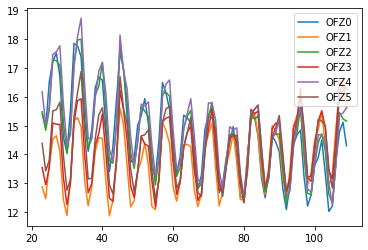

In [41]:
res.plot()

In [42]:
of_res = res[['OFZ0','OFZ1', 'OFZ2', 'OFZ3', 'OFZ4', 'OFZ5']].copy()
of_res

,OFZ0,OFZ1,OFZ2,OFZ3,OFZ4,OFZ5
23,15.405675,12.877311,15.484019,13.550748,16.173586,14.384924
24,14.931154,12.464343,14.843074,12.948333,15.046368,13.429861
25,16.515097,13.656087,15.541600,13.524177,15.666541,13.801317
26,17.218218,14.528187,17.305103,15.090350,17.459633,15.509411
27,17.515217,14.652087,17.244055,15.050405,17.560143,15.552138
...,...,...,...,...,...,...
105,12.210277,13.306490,12.315461,13.157657,12.263429,12.836651
106,13.792394,14.921235,13.731971,14.545489,13.644016,14.115857
107,14.787488,16.106730,15.450961,16.572363,15.372490,16.160898
108,15.117647,16.515930,15.233692,16.336452,15.438622,16.194305


In [43]:
of_res.mean()

OFZ0    14.581544
OFZ1    13.825301
OFZ2    14.696161
OFZ3    14.158553
OFZ4    14.913833
OFZ5    14.329033
dtype: float64

In [385]:
of_res2.mean()

OFZ0    13.343808
OFZ1    13.083831
OFZ2    12.130546
OFZ3    11.823548
OFZ4    10.232239
OFZ5    11.642468
dtype: float64

In [384]:
of_res.std()

OFZ0    3.426351
OFZ1    2.205522
OFZ2    2.369845
OFZ3    3.500570
OFZ4    2.605586
OFZ5    1.767063
dtype: float64

In [386]:
of_res2.std()

OFZ0    3.722503
OFZ1    2.619945
OFZ2    2.538541
OFZ3    3.688748
OFZ4    2.429765
OFZ5    1.944991
dtype: float64

# Plot histogram of the optical flow to check the distribution

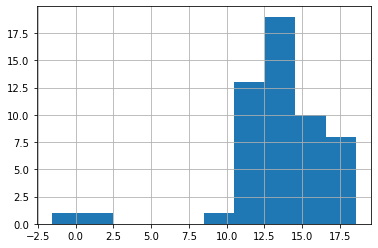

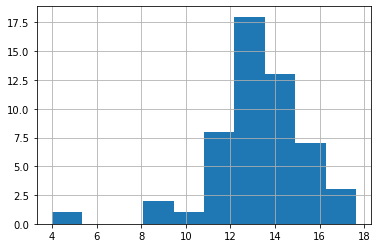

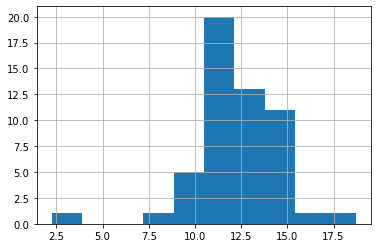

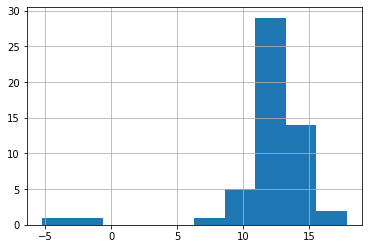

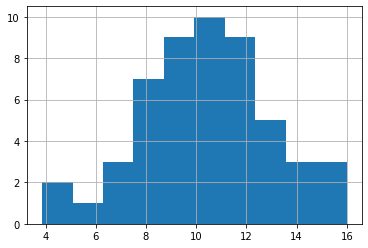

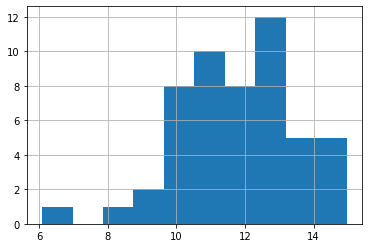

In [387]:
for col in of_res.columns:
    res[col].hist()
    plt.title=col
    plt.show()

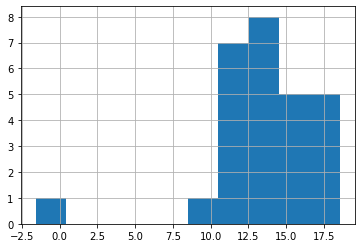

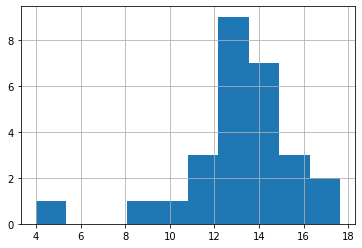

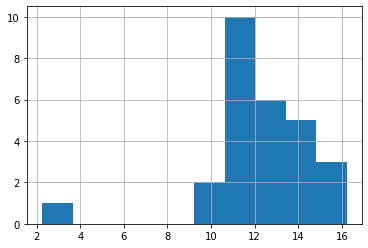

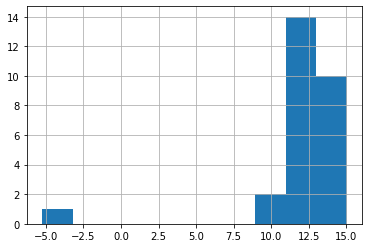

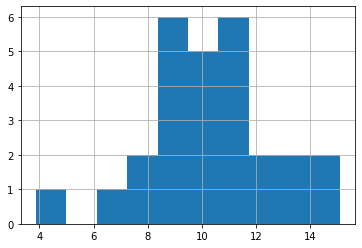

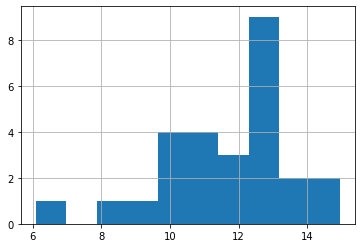

In [388]:
for col in of_res2.columns:
    of_res2[col].hist()
    plt.title=col
    plt.show()

## Use statistical methods to clean outliers from the data

In [389]:
means = of_res.mean()
stds = of_res.std()

num_std_dev =1.0

for col in of_res.columns:
    of_res.loc[:,col] = of_res[col].apply(lambda x: x if ((x>means[col]-num_std_dev*stds[col]) and (x<means[col]+num_std_dev*stds[col])) else np.nan).copy()

In [390]:
means = of_res2.mean()
stds = of_res2.std()

num_std_dev =1.0

for col in of_res2.columns:
    of_res2.loc[:,col] = of_res2[col].apply(lambda x: x if ((x>means[col]-num_std_dev*stds[col]) and (x<means[col]+num_std_dev*stds[col])) else np.nan).copy()

In [392]:
of_res

,OFZ0,OFZ1,OFZ2,OFZ3,OFZ4,OFZ5
29,NaN,NaN,NaN,NaN,8.538836,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN
31,11.132250,NaN,14.235498,15.013303,9.688616,12.526033
32,15.011619,13.945156,11.922591,11.140269,11.169121,10.735797
33,NaN,14.958532,12.382684,11.699794,9.378431,13.335948
34,13.328088,12.160350,NaN,13.914412,7.938611,11.987364
35,13.190943,12.243046,11.856373,11.586879,10.691122,10.609481
36,16.334723,14.469913,11.901287,11.096518,8.110641,12.026337
37,12.958664,12.125822,13.688688,13.071508,10.639080,12.939234
38,12.981710,11.842814,14.265706,13.094186,10.909926,10.608641


In [393]:
of_res2

,OFZ0,OFZ1,OFZ2,OFZ3,OFZ4,OFZ5
29,NaN,NaN,NaN,NaN,8.538836,NaN
31,11.132250,NaN,14.235498,15.013303,9.688616,12.526033
33,NaN,14.958532,12.382684,11.699794,9.378431,13.335948
35,13.190943,12.243046,11.856373,11.586879,10.691122,10.609481
37,12.958664,12.125822,13.688688,13.071508,10.639080,12.939234
39,NaN,NaN,NaN,14.999073,NaN,NaN
41,12.322905,11.246502,11.365714,10.463751,NaN,NaN
43,16.636375,14.752152,11.790757,11.047338,NaN,12.345029
45,13.708220,12.669010,NaN,14.311564,11.573172,11.003612
47,15.726617,14.133150,12.449100,11.737396,NaN,NaN


In [394]:
of_res.mean()

OFZ0    13.454506
OFZ1    13.249121
OFZ2    12.193598
OFZ3    12.300686
OFZ4    10.343478
OFZ5    11.596395
dtype: float64

In [395]:
of_res2.mean()

OFZ0    13.574105
OFZ1    13.335157
OFZ2    12.130896
OFZ3    12.479934
OFZ4    10.214077
OFZ5    11.782134
dtype: float64